# Jaspal Singh Bainiwal
# MRP
2025
TMU

In [9]:

import pandas as pd
import numpy as np
import os


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
import shap


In [3]:
!pip install xgboost
from xgboost import XGBRegressor


In [5]:
from google.colab import drive

drive.mount('/content/drive')

#project paths
base_path = '/content/drive/MyDrive/CropYield_MRP'
data_path = f'{base_path}/data'
model_path = f'{base_path}/models'

os.makedirs(model_path, exist_ok=True)

print("Data files:", os.listdir(data_path))



Mounted at /content/drive
Data files: ['all_regions_weather_weekly_with_yield.csv', 'yearly_enriched.csv', 'seasonal_enriched.csv', 'seasonal_enriched.gsheet']


In [ ]:
file_path = f'{data_path}/yearly_enriched.csv'
df = pd.read_csv(file_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()



Shape: (6753, 276)
Columns: ['source_region', 'region', 'crop', 'year', 'weather_code_mean', 'weather_code_max', 'weather_code_min', 'weather_code_std', 'temperature_2m_mean_mean', 'temperature_2m_mean_max', 'temperature_2m_mean_min', 'temperature_2m_mean_std', 'temperature_2m_max_mean', 'temperature_2m_max_max', 'temperature_2m_max_min', 'temperature_2m_max_std', 'temperature_2m_min_mean', 'temperature_2m_min_max', 'temperature_2m_min_min', 'temperature_2m_min_std', 'apparent_temperature_mean_mean', 'apparent_temperature_mean_max', 'apparent_temperature_mean_min', 'apparent_temperature_mean_std', 'apparent_temperature_max_mean', 'apparent_temperature_max_max', 'apparent_temperature_max_min', 'apparent_temperature_max_std', 'apparent_temperature_min_mean', 'apparent_temperature_min_max', 'apparent_temperature_min_min', 'apparent_temperature_min_std', 'sunrise_mean', 'sunrise_max', 'sunrise_min', 'sunrise_std', 'sunset_mean', 'sunset_max', 'sunset_min', 'sunset_std', 'daylight_duration_

,source_region,region,crop,year,weather_code_mean,weather_code_max,weather_code_min,weather_code_std,temperature_2m_mean_mean,temperature_2m_mean_max,...,yield_min,yield_std,yield_lb_per_acre_mean,yield_lb_per_acre_max,yield_lb_per_acre_min,yield_lb_per_acre_std,month_mean,month_max,month_min,month_std
0,california,ALAMEDA,BARLEY,1998,21.608219,65.0,0.0,25.894719,56.443803,86.503700,...,50.000000,4.082690,NaN,NaN,NaN,NaN,6.526027,12,1,3.448026
1,california,ALAMEDA,BARLEY,1999,12.457534,73.0,0.0,21.139662,56.506906,83.503710,...,55.000000,8.165380,NaN,NaN,NaN,NaN,6.526027,12,1,3.448026
2,california,ALAMEDA,BARLEY,2000,15.620219,63.0,0.0,23.131486,57.247501,85.656200,...,51.800000,8.250401,NaN,NaN,NaN,NaN,6.513661,12,1,3.451409
3,california,ALAMEDA,BARLEY,2001,12.978082,71.0,0.0,21.883850,57.845193,83.207440,...,30.000000,6.726080,NaN,NaN,NaN,NaN,6.526027,12,1,3.448026
4,california,ALAMEDA,BARLEY,2002,11.904110,71.0,0.0,21.033362,57.486673,81.624954,...,52.996187,0.000000,NaN,NaN,NaN,NaN,6.526027,12,1,3.450215


In [ ]:
#load dataset
file_path = f'{data_path}/yearly_enriched.csv'
df = pd.read_csv(file_path)

#normalize column names
df.columns = df.columns.str.lower()

#target column
target = 'yield_mean'

#drop rows where target is missing
df = df.dropna(subset=[target])

#drop leakage columns
leakage_cols = [col for col in df.columns if col.startswith('yield_') or col.startswith('production') or col.startswith('area')]
df_clean = df.drop(columns=leakage_cols, errors='ignore')

#categorical & numeric columns
categorical_cols = ['source_region', 'region', 'crop']
numeric_cols = df_clean.select_dtypes(include='number').columns.drop(['year'], errors='ignore')

X = df_clean[categorical_cols + numeric_cols.tolist()]
y = df[target]

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)






In [ ]:
numeric_cols = X_train.select_dtypes(include='number').columns.tolist()

#drop columns where all values are NaN
nan_cols = [col for col in numeric_cols if X_train[col].isna().all()]
if nan_cols:
    print("Dropping all-NaN columns:", nan_cols)
    X_train = X_train.drop(columns=nan_cols)
    X_test = X_test.drop(columns=nan_cols, errors='ignore')
    numeric_cols = [col for col in numeric_cols if col not in nan_cols]

#impute numeric columns
num_imputer = SimpleImputer(strategy='mean')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

#impute categorical columns (already defined in Cell 3)
for col in categorical_cols:
    X_train[col] = X_train[col].fillna('missing')
    X_test[col] = X_test[col].fillna('missing')



Dropping all-NaN columns: ['precipitation_probability_mean_mean', 'precipitation_probability_mean_max', 'precipitation_probability_mean_min', 'precipitation_probability_mean_std', 'precipitation_probability_min_mean', 'precipitation_probability_min_max', 'precipitation_probability_min_min', 'precipitation_probability_min_std', 'visibility_max_mean', 'visibility_max_max', 'visibility_max_min', 'visibility_max_std', 'visibility_min_mean', 'visibility_min_max', 'visibility_min_min', 'visibility_min_std', 'visibility_mean_mean', 'visibility_mean_max', 'visibility_mean_min', 'visibility_mean_std', 'updraft_max_mean', 'updraft_max_max', 'updraft_max_min', 'updraft_max_std', 'soil_moisture_0_to_10cm_mean_mean', 'soil_moisture_0_to_10cm_mean_max', 'soil_moisture_0_to_10cm_mean_min', 'soil_moisture_0_to_10cm_mean_std']


In [ ]:
#detect column types from X_train
numeric_cols = X_train.select_dtypes(include='number').columns.tolist()
categorical_cols = X_train.select_dtypes(exclude='number').columns.tolist()

#build preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])



In [ ]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)


In [ ]:
def evaluate_model(name, model):
    model.fit(X_train_prep, y_train)
    preds = model.predict(X_test_prep)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}


In [ ]:
results = []
results.append(evaluate_model("Linear Regression", LinearRegression()))
results.append(evaluate_model("Random Forest", RandomForestRegressor(n_estimators=200, random_state=42)))
results.append(evaluate_model("Gradient Boosting", GradientBoostingRegressor(n_estimators=200, random_state=42)))

import pandas as pd
results_df = pd.DataFrame(results)
results_df


,Model,RMSE,MAE,R2
0,Linear Regression,9.438168,5.705550,0.908339
1,Random Forest,7.813108,4.179622,0.937186
2,Gradient Boosting,7.913594,4.589172,0.935560


In [ ]:
best_model = RandomForestRegressor(n_estimators=200, random_state=42)
best_model.fit(X_train_prep, y_train)
joblib.dump(best_model, f'{model_path}/trained_model.pkl')
print("Model saved to:", f'{model_path}/trained_model.pkl')


Model saved to: /content/drive/MyDrive/CropYield_MRP/models/trained_model.pkl


In [ ]:
#save experiment 1 results
exp1_path = f'{model_path}/experiment1_results.csv'
results_df.to_csv(exp1_path, index=False)
print("Experiment 1 results saved to:", exp1_path)


Experiment 1 results saved to: /content/drive/MyDrive/CropYield_MRP/models/experiment1_results.csv


Feature importance saved to: /content/drive/MyDrive/CropYield_MRP/models/experiment2_feature_importance.csv


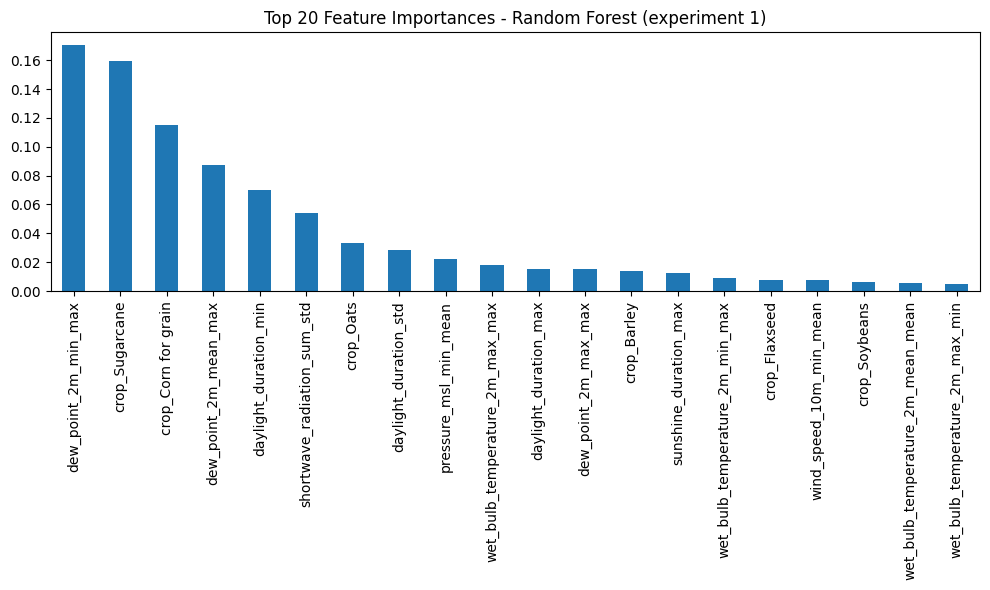

In [ ]:
#extract feature importances from trained Random Forest
best_rf = RandomForestRegressor(n_estimators=200, random_state=42)
best_rf.fit(X_train_prep, y_train)

#get feature names from preprocessor
onehot_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
all_features = numeric_cols + onehot_features

importances = pd.Series(best_rf.feature_importances_, index=all_features).sort_values(ascending=False)

#save feature importance
fi_path = f'{model_path}/experiment2_feature_importance.csv'
importances.to_csv(fi_path)
print("Feature importance saved to:", fi_path)

#plot top 20 features
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
importances.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances - Random Forest (experiment 1)")
plt.tight_layout()
plt.show()


experiment 2

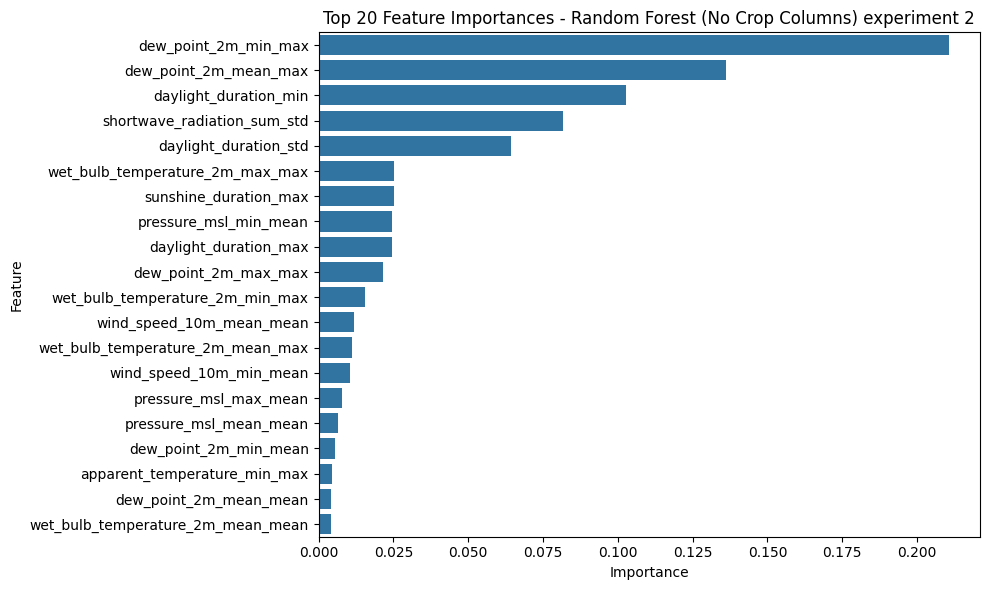

Performance without crop features:
RMSE: 22.3643, MAE: 13.2316, R2: 0.4853


In [ ]:
#remove the crop column entirely
X_train_no_crop = X_train.drop(columns=['crop'], errors='ignore').copy()
X_test_no_crop = X_test.drop(columns=['crop'], errors='ignore').copy()

#
numeric_cols_nc = X_train_no_crop.select_dtypes(include='number').columns.tolist()
categorical_cols_nc = X_train_no_crop.select_dtypes(exclude='number').columns.tolist()

preprocessor_nc = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols_nc),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_nc)
])

X_train_prep_nc = preprocessor_nc.fit_transform(X_train_no_crop)
X_test_prep_nc = preprocessor_nc.transform(X_test_no_crop)

rf_nc = RandomForestRegressor(n_estimators=200, random_state=42)
rf_nc.fit(X_train_prep_nc, y_train)

#get feature importance
feature_names_nc = numeric_cols_nc + list(preprocessor_nc.named_transformers_['cat'].get_feature_names_out(categorical_cols_nc))
feat_imp_nc = pd.DataFrame({'Feature': feature_names_nc, 'Importance': rf_nc.feature_importances_})
feat_imp_nc = feat_imp_nc.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_nc.head(20))
plt.title('Top 20 Feature Importances - Random Forest (No Crop Columns) experiment 2')
plt.tight_layout()
plt.show()

preds_nc = rf_nc.predict(X_test_prep_nc)
print(f"Performance without crop features:\nRMSE: {np.sqrt(mean_squared_error(y_test, preds_nc)):.4f}, MAE: {mean_absolute_error(y_test, preds_nc):.4f}, R2: {r2_score(y_test, preds_nc):.4f}")


experiment 3

In [ ]:

unique_crops = df['crop'].unique()
print("Crops found:", unique_crops)

#dict to store results per crop
crop_results = {}


Crops found: ['BARLEY' 'Barley' 'Corn for grain' 'Oats' 'Soybeans' 'Wheat, all'
 'Canola' 'Flaxseed' 'Peas, dry' 'Rye, all' 'Rye, fall remaining'
 'Rye, spring' 'Wheat, durum' 'Wheat, spring' 'Wheat, winter remaining'
 'Triticale' 'Arhar/Tur' 'Bajra' 'Cotton(lint)' 'Gram' 'Maize' 'Masoor'
 'Moong(Green Gram)' 'Other Rabi pulses' 'Peas & beans (Pulses)'
 'Rapeseed &Mustard' 'Rice' 'Sesamum' 'Sugarcane' 'Sunflower' 'Urad'
 'Wheat' 'Groundnut' 'Guar seed' 'Moth' 'other oilseeds' 'Linseed']


In [ ]:
def train_crop_model(crop_name):
    df_crop = df[df['crop'] == crop_name].copy()

    X_crop = df_crop.drop(columns=['yield_mean', 'crop'])
    y_crop = df_crop['yield_mean']

    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_crop, y_crop, test_size=0.3, random_state=42
    )

    numeric_cols_c = X_train_c.select_dtypes(include='number').columns.tolist()
    categorical_cols_c = X_train_c.select_dtypes(exclude='number').columns.tolist()

    nan_cols_c = [col for col in numeric_cols_c if X_train_c[col].isna().all()]
    if nan_cols_c:
        X_train_c = X_train_c.drop(columns=nan_cols_c)
        X_test_c = X_test_c.drop(columns=nan_cols_c, errors='ignore')
        numeric_cols_c = [c for c in numeric_cols_c if c not in nan_cols_c]

    num_imputer_c = SimpleImputer(strategy='mean')
    X_train_c[numeric_cols_c] = num_imputer_c.fit_transform(X_train_c[numeric_cols_c])
    X_test_c[numeric_cols_c] = num_imputer_c.transform(X_test_c[numeric_cols_c])

    for col in categorical_cols_c:
        if col in X_train_c.columns:
            X_train_c[col] = X_train_c[col].fillna('missing')
        if col in X_test_c.columns:
            X_test_c[col] = X_test_c[col].fillna('missing')

    preprocessor_c = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_cols_c),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_c)
    ])

    X_train_prep_c = preprocessor_c.fit_transform(X_train_c)
    X_test_prep_c = preprocessor_c.transform(X_test_c)

    rf_c = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_c.fit(X_train_prep_c, y_train_c)

    preds_c = rf_c.predict(X_test_prep_c)
    rmse_c = np.sqrt(mean_squared_error(y_test_c, preds_c))
    mae_c = mean_absolute_error(y_test_c, preds_c)
    r2_c = r2_score(y_test_c, preds_c)

    crop_results[crop_name] = {'RMSE': rmse_c, 'MAE': mae_c, 'R2': r2_c}
    print(f"{crop_name} → RMSE: {rmse_c:.3f}, MAE: {mae_c:.3f}, R2: {r2_c:.3f}")

    return rf_c


In [ ]:
trained_crop_models = {}

for crop in unique_crops:
    trained_crop_models[crop] = train_crop_model(crop)

crop_results_df = pd.DataFrame(crop_results).T
crop_results_df.sort_values(by='R2', ascending=False)


BARLEY → RMSE: 3.995, MAE: 2.718, R2: 0.968
Barley → RMSE: 0.588, MAE: 0.267, R2: 1.000
Corn for grain → RMSE: 3.271, MAE: 2.357, R2: 0.979
Oats → RMSE: 1.328, MAE: 0.551, R2: 0.993
Soybeans → RMSE: 1.371, MAE: 0.619, R2: 0.973
Wheat, all → RMSE: 1.015, MAE: 0.422, R2: 0.996
Canola → RMSE: 0.711, MAE: 0.386, R2: 0.994
Flaxseed → RMSE: 0.586, MAE: 0.392, R2: 0.995
Peas, dry → RMSE: 1.243, MAE: 0.697, R2: 0.990
Rye, all → RMSE: 4.685, MAE: 3.001, R2: 0.884
Rye, fall remaining → RMSE: 2.086, MAE: 1.298, R2: 0.982
Rye, spring → RMSE: 12.583, MAE: 10.717, R2: 0.412
Wheat, durum → RMSE: 0.976, MAE: 0.556, R2: 0.991
Wheat, spring → RMSE: 1.437, MAE: 0.679, R2: 0.990
Wheat, winter remaining → RMSE: 5.523, MAE: 2.243, R2: 0.901
Triticale → RMSE: 10.319, MAE: 5.812, R2: 0.676
Arhar/Tur → RMSE: 0.040, MAE: 0.015, R2: 0.930
Bajra → RMSE: 0.225, MAE: 0.062, R2: 0.479
Cotton(lint) → RMSE: 0.204, MAE: 0.095, R2: 0.978
Gram → RMSE: 0.049, MAE: 0.025, R2: 0.982
Maize → RMSE: 0.140, MAE: 0.051, R2: 0.97

,RMSE,MAE,R2
Linseed,0.000000,0.000000,1.000000
Barley,0.588217,0.266540,0.999540
Wheat,0.023998,0.012547,0.997495
"Wheat, all",1.014602,0.422454,0.996187
Rice,0.040460,0.016127,0.995619
Flaxseed,0.586495,0.391846,0.995199
Sugarcane,1.250916,0.753677,0.994691
Canola,0.710704,0.386215,0.993834
Oats,1.328039,0.550515,0.993305
Rapeseed &Mustard,0.031997,0.010771,0.991494


In [ ]:

crop_results_df = pd.DataFrame(crop_results).T.reset_index()
crop_results_df.columns = ["Crop", "RMSE", "MAE", "R2"]

crop_results_df = crop_results_df.sort_values(by="R2", ascending=False)

results_path = f"{model_path}/experiment3_crop_results.csv"
crop_results_df.to_csv(results_path, index=False)
print(f"Crop-wise results saved to: {results_path}")

print(crop_results_df.head(10))


Crop-wise results saved to: /content/drive/MyDrive/CropYield_MRP/models/experiment3_crop_results.csv
                 Crop      RMSE       MAE        R2
36            Linseed  0.000000  0.000000  1.000000
1              Barley  0.588217  0.266540  0.999540
31              Wheat  0.023998  0.012547  0.997495
5          Wheat, all  1.014602  0.422454  0.996187
26               Rice  0.040460  0.016127  0.995619
7            Flaxseed  0.586495  0.391846  0.995199
28          Sugarcane  1.250916  0.753677  0.994691
6              Canola  0.710704  0.386215  0.993834
3                Oats  1.328039  0.550515  0.993305
25  Rapeseed &Mustard  0.031997  0.010771  0.991494


In [ ]:

file_path = f'{data_path}/yearly_enriched.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower()

target = 'yield_mean'

leakage_cols = [col for col in df.columns if ('yield' in col or 'production' in col or 'area' in col) and col != target]
df_clean = df.drop(columns=leakage_cols, errors='ignore')

#define crop groups
cereal = ['wheat', 'wheat, all', 'wheat, durum', 'wheat, spring', 'wheat, winter remaining', 'barley', 'oats', 'rye, all', 'rye, fall remaining', 'rye, spring', 'corn for grain', 'triticale', 'maize']
oilseed = ['canola', 'flaxseed', 'soybeans', 'sunflower', 'rapeseed &mustard', 'groundnut', 'sesamum', 'other oilseeds']
legumes = ['peas, dry', 'gram', 'masoor', 'urad', 'moong(green gram)', 'arhar/tur', 'peas & beans (pulses)', 'guar seed', 'other rabi pulses', 'moth']
industrial = ['sugarcane', 'cotton(lint)']
other = ['bajra']

def map_crop_group(crop):
    crop_lower = str(crop).lower()
    if any(c in crop_lower for c in cereal): return 'Cereal'
    if any(c in crop_lower for c in oilseed): return 'Oilseed'
    if any(c in crop_lower for c in legumes): return 'Legumes'
    if any(c in crop_lower for c in industrial): return 'Industrial'
    return 'Other'

df_clean['crop_group'] = df['crop'].apply(map_crop_group)

df_clean = df_clean.dropna(subset=[target])

print("Columns used:", df_clean.columns.tolist())


Columns used: ['source_region', 'region', 'crop', 'year', 'weather_code_mean', 'weather_code_max', 'weather_code_min', 'weather_code_std', 'temperature_2m_mean_mean', 'temperature_2m_mean_max', 'temperature_2m_mean_min', 'temperature_2m_mean_std', 'temperature_2m_max_mean', 'temperature_2m_max_max', 'temperature_2m_max_min', 'temperature_2m_max_std', 'temperature_2m_min_mean', 'temperature_2m_min_max', 'temperature_2m_min_min', 'temperature_2m_min_std', 'apparent_temperature_mean_mean', 'apparent_temperature_mean_max', 'apparent_temperature_mean_min', 'apparent_temperature_mean_std', 'apparent_temperature_max_mean', 'apparent_temperature_max_max', 'apparent_temperature_max_min', 'apparent_temperature_max_std', 'apparent_temperature_min_mean', 'apparent_temperature_min_max', 'apparent_temperature_min_min', 'apparent_temperature_min_std', 'sunrise_mean', 'sunrise_max', 'sunrise_min', 'sunrise_std', 'sunset_mean', 'sunset_max', 'sunset_min', 'sunset_std', 'daylight_duration_mean', 'daylig

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Skipping features without any observed values")

def train_group_model(group_name, group_df):
    X = group_df.drop(columns=[target])
    y = group_df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


    numeric_cols = X_train.select_dtypes(include='number').columns.tolist()
    categorical_cols = X_train.select_dtypes(exclude='number').columns.tolist()

    #build preprocessing pipeline
    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numeric_cols),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_cols)
    ])

    results = []
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
    }

    for name, model in models.items():
        pipe = Pipeline(steps=[('pre', preprocessor), ('model', model)])
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        results.append([group_name, name, rmse, mae, r2])

    return results

crop_group_results = []
for group in df_clean['crop_group'].unique():
    group_df = df_clean[df_clean['crop_group'] == group]
    if len(group_df) > 30:
        crop_group_results.extend(train_group_model(group, group_df))

crop_group_results_df = pd.DataFrame(crop_group_results, columns=['Group', 'Model', 'RMSE', 'MAE', 'R2'])
crop_group_results_df.sort_values(by=['R2', 'Group'], ascending=[False,True])

,Group,Model,RMSE,MAE,R2
14,Industrial,Gradient Boosting,6.575523,4.363424,0.963774
13,Industrial,Random Forest,6.688552,3.920665,0.962518
10,Other,Random Forest,0.280015,0.197533,0.945970
11,Other,Gradient Boosting,0.284974,0.200893,0.944039
4,Oilseed,Random Forest,4.283447,2.358633,0.931131
5,Oilseed,Gradient Boosting,4.312556,2.293357,0.930192
6,Legumes,Linear Regression,3.792532,1.956812,0.926149
8,Legumes,Gradient Boosting,3.903433,1.373953,0.921767
7,Legumes,Random Forest,4.210859,1.440215,0.908959
3,Oilseed,Linear Regression,5.396866,3.664264,0.890675


In [ ]:
results_path = f"{model_path}/experiment4_crop_group_results.csv"
crop_group_results_df.to_csv(results_path, index=False)
print("results saved to:", results_path)


results saved to: /content/drive/MyDrive/CropYield_MRP/models/experiment4_crop_group_results.csv


# experiment 5

In [ ]:

file_path = f'{data_path}/seasonal_enriched.csv'
df = pd.read_csv(file_path)

df.columns = df.columns.str.lower()

target = 'yield_mean_t_ha'

df = df.dropna(subset=[target])

#drop leakage columns
leakage_cols = [col for col in df.columns if col.startswith('yield_') or col.startswith('production') or col.startswith('area')]
df_clean = df.drop(columns=leakage_cols, errors='ignore')

categorical_cols = ['source_region', 'region', 'crop', 'season']
numeric_cols = df_clean.select_dtypes(include='number').columns.drop(['year'], errors='ignore')


In [ ]:
X = df_clean[categorical_cols + numeric_cols.tolist()]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
numeric_cols = X_train.select_dtypes(include='number').columns.tolist()

#drop columns that are all NaN
nan_cols = [col for col in numeric_cols if X_train[col].isna().all()]
X_train = X_train.drop(columns=nan_cols)
X_test = X_test.drop(columns=nan_cols, errors='ignore')
numeric_cols = [col for col in numeric_cols if col not in nan_cols]

num_imputer = SimpleImputer(strategy='mean')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

for col in categorical_cols:
    X_train[col] = X_train[col].fillna('missing')
    X_test[col] = X_test[col].fillna('missing')


In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

In [ ]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)


In [ ]:
results = []
results.append(evaluate_model("Linear Regression", LinearRegression()))
results.append(evaluate_model("Random Forest", RandomForestRegressor(n_estimators=200, random_state=42)))
results.append(evaluate_model("Gradient Boosting", GradientBoostingRegressor(n_estimators=200, random_state=42)))

results_df = pd.DataFrame(results)
results_df


,Model,RMSE,MAE,R2
0,Linear Regression,3.684374,1.196274,0.921886
1,Random Forest,1.190958,0.464166,0.991838
2,Gradient Boosting,1.388955,0.621287,0.988899


In [ ]:
results_df.to_csv(f'{base_path}/experiment5_seasonal_results.csv', index=False)
print("Experiment 5 results saved.")


Experiment 5 results saved.


===========

experiment 6

============

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:13:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


               Model       RMSE        MAE        R2
0  Linear Regression  20.458630  12.405830  0.569315
1      Random Forest  22.379434  13.251685  0.484647
2  Gradient Boosting  21.171762  12.581622  0.538766
3            XGBoost  22.377537  13.233820  0.484734


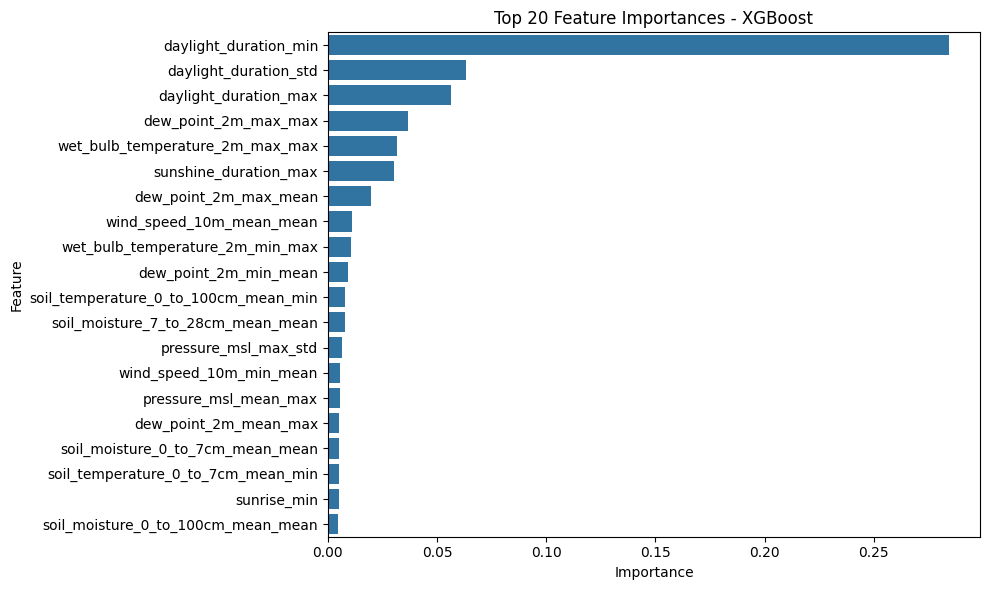

In [ ]:
base_path = '/content/drive/MyDrive/CropYield_MRP'
data_path = f'{base_path}/data'
model_path = f'{base_path}/models'
os.makedirs(model_path, exist_ok=True)

file_path = f'{data_path}/yearly_enriched.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower()

target = 'yield_mean'
df = df.dropna(subset=[target])

leakage_cols = [col for col in df.columns if col.startswith('yield_') or col.startswith('production') or col.startswith('area')]
df_clean = df.drop(columns=leakage_cols, errors='ignore')

categorical_cols = ['source_region', 'region', 'crop']
numeric_cols = df_clean.select_dtypes(include='number').columns.drop(['year'], errors='ignore')

X = df_clean[categorical_cols + numeric_cols.tolist()]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.drop(columns=['region'], errors='ignore')
X_test = X_test.drop(columns=['region'], errors='ignore')


non_leak_features = [col for col in X_train.columns if not (col.startswith('crop_') or col.startswith('region_'))]
X_train = X_train[non_leak_features].copy()
X_test = X_test[non_leak_features].copy()

numeric_cols = X_train.select_dtypes(include='number').columns.tolist()
categorical_cols = [col for col in X_train.select_dtypes(exclude='number').columns if col != 'crop']

nan_cols = [col for col in numeric_cols if X_train[col].isna().all()]
if nan_cols:
    X_train = X_train.drop(columns=nan_cols)
    X_test = X_test.drop(columns=nan_cols, errors='ignore')
    numeric_cols = [col for col in numeric_cols if col not in nan_cols]


num_imputer = SimpleImputer(strategy='mean')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])


for col in categorical_cols:
    X_train[col] = X_train[col].fillna('missing')
    X_test[col] = X_test[col].fillna('missing')

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])


X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)


def evaluate_model(name, model):
    model.fit(X_train_prep, y_train)
    preds = model.predict(X_test_prep)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}


importances_exp6 = None

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    predictor='gpu_predictor',
    random_state=42
)

results = []
results.append(evaluate_model("Linear Regression", LinearRegression()))
results.append(evaluate_model("Random Forest", RandomForestRegressor(n_estimators=200, random_state=42)))
results.append(evaluate_model("Gradient Boosting", GradientBoostingRegressor(n_estimators=200, random_state=42)))

xgb_model.fit(X_train_prep, y_train)
preds_xgb = xgb_model.predict(X_test_prep)
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))
mae_xgb = mean_absolute_error(y_test, preds_xgb)
r2_xgb = r2_score(y_test, preds_xgb)

results.append({"Model": "XGBoost", "RMSE": rmse_xgb, "MAE": mae_xgb, "R2": r2_xgb})

results_df = pd.DataFrame(results)
print(results_df)

# ===========================
# Feature Importance – XGBoost
# ===========================
feature_names = numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
importances = xgb_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

feat_imp.to_csv(f"{model_path}/xgboost_feature_importance.csv", index=False)


plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(20))
plt.title('Top 20 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()

In [ ]:
#save experiment 6 xgboost model
joblib.dump(xgb_model, f"{model_path}/xgboost_exp6.pkl")
print("XGBoost model saved to:", f"{model_path}/xgboost_exp6.pkl")


XGBoost model saved to: /content/drive/MyDrive/CropYield_MRP/models/xgboost_exp6.pkl


# experiment 7

Experiment 7 – Weather Only (No Crop/Region) Results
               Model       RMSE       MAE        R2
0  Linear Regression  14.075083  6.366099  0.348211
1      Random Forest  14.947848  6.190804  0.264873
2  Gradient Boosting  13.903613  5.789304  0.363996
3            XGBoost  14.689015  6.036669  0.290111
Saved: /content/drive/MyDrive/CropYield_MRP/models/experiment7_LinearRegression.pkl
Saved: /content/drive/MyDrive/CropYield_MRP/models/experiment7_RandomForest.pkl
Saved: /content/drive/MyDrive/CropYield_MRP/models/experiment7_GradientBoosting.pkl
Saved: /content/drive/MyDrive/CropYield_MRP/models/experiment7_XGBoost.pkl


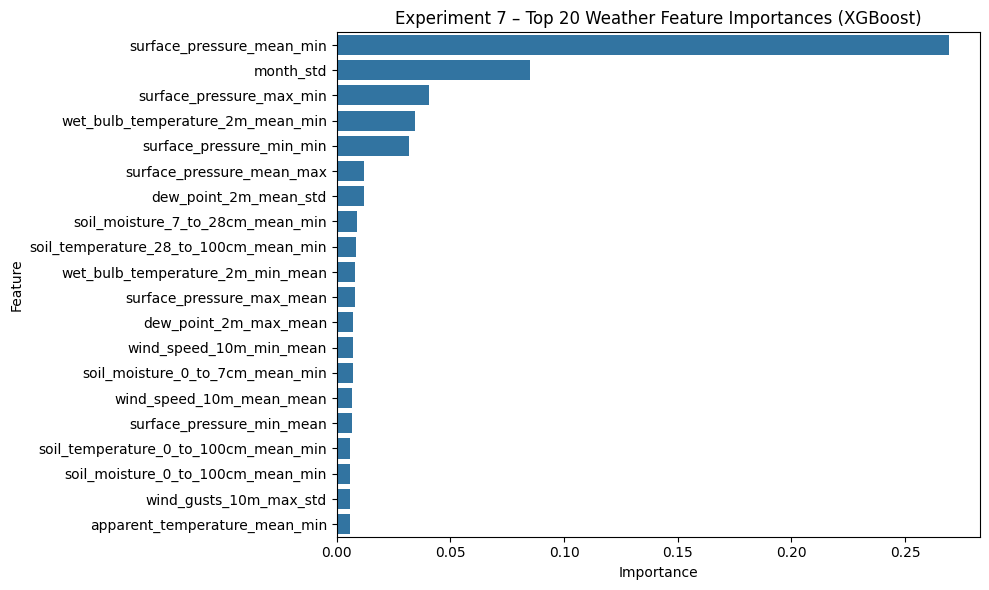

saved to: /content/drive/MyDrive/CropYield_MRP/models/experiment7_xgb_weather_model.pkl


In [ ]:
base_path = '/content/drive/MyDrive/CropYield_MRP'
data_path = f'{base_path}/data'
model_path = f'{base_path}/models'
os.makedirs(model_path, exist_ok=True)

file_path = f'{data_path}/seasonal_enriched.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower()

target = 'yield_mean_t_ha'
df = df.dropna(subset=[target])

leakage_cols = [col for col in df.columns if col.startswith('yield_') or col.startswith('production') or col.startswith('area')]
df_clean = df.drop(columns=leakage_cols, errors='ignore')

categorical_cols = [col for col in ['season'] if col in df_clean.columns]
numeric_cols = df_clean.select_dtypes(include='number').columns.drop(['year'], errors='ignore')

X = df_clean[categorical_cols + numeric_cols.tolist()]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

nan_cols = [col for col in numeric_cols if X_train[col].isna().all()]
if nan_cols:
    X_train = X_train.drop(columns=nan_cols)
    X_test = X_test.drop(columns=nan_cols, errors='ignore')
    numeric_cols = [col for col in numeric_cols if col not in nan_cols]

num_imputer = SimpleImputer(strategy='mean')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

for col in categorical_cols:
    X_train[col] = X_train[col].fillna('missing')
    X_test[col] = X_test[col].fillna('missing')

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

def evaluate_model(name, model):
    model.fit(X_train_prep, y_train)
    preds = model.predict(X_test_prep)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}, model

results = []
models_trained = {}

res, model_lr = evaluate_model("Linear Regression", LinearRegression())
results.append(res)
models_trained["LinearRegression"] = model_lr

res, model_rf = evaluate_model("Random Forest", RandomForestRegressor(n_estimators=200, random_state=42))
results.append(res)
models_trained["RandomForest"] = model_rf

res, model_gb = evaluate_model("Gradient Boosting", GradientBoostingRegressor(n_estimators=200, random_state=42))
results.append(res)
models_trained["GradientBoosting"] = model_gb

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    tree_method='hist',
    random_state=42
)
res, model_xgb = evaluate_model("XGBoost", xgb_model)
results.append(res)
models_trained["XGBoost"] = model_xgb

results_df = pd.DataFrame(results)
print("Experiment 7 – Weather Only (No Crop/Region) Results")
print(results_df)

for name, mdl in models_trained.items():
    model_file = f"{model_path}/experiment7_{name}.pkl"
    joblib.dump(mdl, model_file)
    print(f"Saved: {model_file}")

feature_names = numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
importances = model_xgb.feature_importances_
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

feat_imp.to_csv(f"{model_path}/experiment7_xgb_weather_feature_importance.csv", index=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(20))
plt.title('Experiment 7 – Top 20 Weather Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

joblib.dump(model_xgb, f'{model_path}/experiment7_xgb_weather_model.pkl')
print(f"saved to: {model_path}/experiment7_xgb_weather_model.pkl")

# experiment 8

In [ ]:
base_path = '/content/drive/MyDrive/CropYield_MRP'
data_path = f'{base_path}/data'
model_path = f'{base_path}/models'
os.makedirs(model_path, exist_ok=True)

file_path = f'{data_path}/seasonal_enriched.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower()

target = 'yield_mean_t_ha'
df = df.dropna(subset=[target])  # remove rows with missing target

# sample first, then process
sample_df = df.sample(5000, random_state=42).reset_index(drop=True)
y = sample_df[target]

# keep crop (and season) while dropping leakage columns
leakage_cols = [c for c in df.columns if c.startswith('yield_') or c.startswith('production') or c.startswith('area')]
df_clean = sample_df.drop(columns=leakage_cols, errors='ignore')

# define numeric weather columns for rolling
weather_cols = [c for c in df_clean.columns if c not in ['source_region', 'region', 'crop', 'year', 'season']
                and df_clean[c].dtype != 'object']

# create rolling features (on sampled df_clean)
rolling_features = {}
for col in weather_cols:
    rolling_features[f'{col}_roll3'] = df_clean[col].rolling(3, min_periods=1).mean()
    rolling_features[f'{col}_roll7'] = df_clean[col].rolling(7, min_periods=1).mean()

rolling_df = pd.DataFrame(rolling_features, index=df_clean.index)
df_clean = pd.concat([df_clean.reset_index(drop=True), rolling_df.reset_index(drop=True)], axis=1)

# define features
categorical_cols = ['season', 'crop']  # both exist in df_clean
numeric_cols = df_clean.select_dtypes(include='number').columns.drop(['year'], errors='ignore')

X = df_clean[categorical_cols + numeric_cols.tolist()]

y = sample_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


nan_cols = [col for col in numeric_cols if X_train[col].isna().all()]
if nan_cols:
    print("Dropping columns with all NaN:", nan_cols)
    X_train = X_train.drop(columns=nan_cols)
    X_test = X_test.drop(columns=nan_cols, errors='ignore')
    numeric_cols = [col for col in numeric_cols if col not in nan_cols]


num_imputer = SimpleImputer(strategy='mean')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

for col in categorical_cols:
    X_train[col] = X_train[col].fillna('missing')
    X_test[col] = X_test[col].fillna('missing')


preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)


def evaluate_model(name, model):
    model.fit(X_train_prep, y_train)
    preds = model.predict(X_test_prep)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}, model


results = []
models_trained = {}

res, model_lr = evaluate_model("Linear Regression", LinearRegression())
results.append(res)
models_trained["LinearRegression"] = model_lr

res, model_rf = evaluate_model("Random Forest", RandomForestRegressor(n_estimators=200, random_state=42))
results.append(res)
models_trained["RandomForest"] = model_rf

res, model_gb = evaluate_model("Gradient Boosting", GradientBoostingRegressor(n_estimators=200, random_state=42))
results.append(res)
models_trained["GradientBoosting"] = model_gb

xgb_model = XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=8,
    subsample=0.8, colsample_bytree=0.8,
    tree_method='hist', random_state=42
)
res, model_xgb = evaluate_model("XGBoost", xgb_model)
results.append(res)
models_trained["XGBoost"] = model_xgb


results_df = pd.DataFrame(results)
print(results_df)


for name, mdl in models_trained.items():
    model_file = f"{model_path}/experiment8_{name}.pkl"
    joblib.dump(mdl, model_file)
    print(f"Saved: {model_file}")

Dropping columns with all NaN: ['precipitation_probability_mean_mean', 'precipitation_probability_mean_max', 'precipitation_probability_mean_min', 'precipitation_probability_mean_std', 'precipitation_probability_min_mean', 'precipitation_probability_min_max', 'precipitation_probability_min_min', 'precipitation_probability_min_std', 'visibility_max_mean', 'visibility_max_max', 'visibility_max_min', 'visibility_max_std', 'visibility_min_mean', 'visibility_min_max', 'visibility_min_min', 'visibility_min_std', 'visibility_mean_mean', 'visibility_mean_max', 'visibility_mean_min', 'visibility_mean_std', 'updraft_max_mean', 'updraft_max_max', 'updraft_max_min', 'updraft_max_std', 'soil_moisture_0_to_10cm_mean_mean', 'soil_moisture_0_to_10cm_mean_max', 'soil_moisture_0_to_10cm_mean_min', 'soil_moisture_0_to_10cm_mean_std', 'precipitation_probability_mean_mean_roll3', 'precipitation_probability_mean_mean_roll7', 'precipitation_probability_mean_max_roll3', 'precipitation_probability_mean_max_rol

# experiment 8b

Saved: /content/drive/MyDrive/CropYield_MRP/models/experiment8b_LinearRegression.pkl
Saved: /content/drive/MyDrive/CropYield_MRP/models/experiment8b_RandomForest.pkl
Saved: /content/drive/MyDrive/CropYield_MRP/models/experiment8b_GradientBoosting.pkl
Saved: /content/drive/MyDrive/CropYield_MRP/models/experiment8b_XGBoost.pkl
Experiment 8b – Pure Weather (Sampled, Simple Rolling)
               Model       RMSE       MAE        R2
0  Linear Regression  14.703305  8.692417  0.126730
1      Random Forest  13.521150  6.523172  0.261508
2  Gradient Boosting  13.424659  6.220667  0.272010
3            XGBoost  13.396498  6.362052  0.275061


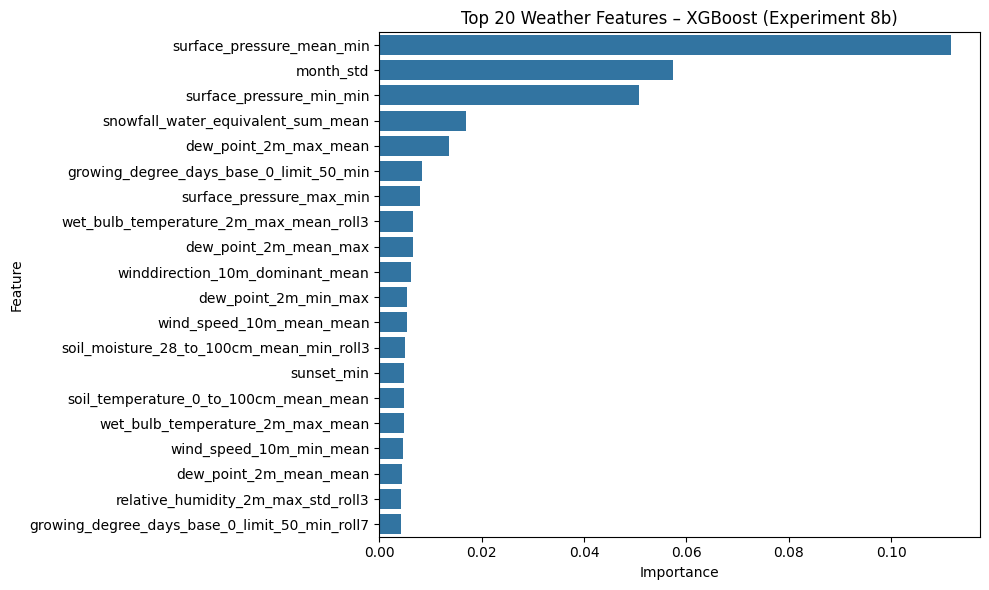

In [ ]:
warnings.filterwarnings('ignore')

base_path = '/content/drive/MyDrive/CropYield_MRP'
data_path = f'{base_path}/data'
model_path = f'{base_path}/models'
os.makedirs(model_path, exist_ok=True)

file_path = f'{data_path}/seasonal_enriched.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower()

target = 'yield_mean_t_ha'
df = df.dropna(subset=[target])

sample_df = df.sample(5000, random_state=42).reset_index(drop=True)


leakage_cols = [c for c in sample_df.columns
                if c.startswith('yield_') or c.startswith('production') or c.startswith('area')]
drop_cols = ['source_region', 'region', 'crop']
df_clean = sample_df.drop(columns=leakage_cols + drop_cols, errors='ignore')


numeric_weather = df_clean.select_dtypes(include='number').columns.drop(['year'], errors='ignore')
rolling_features = {}
for col in numeric_weather:
    rolling_features[f'{col}_roll3'] = df_clean[col].rolling(3, min_periods=1).mean()
    rolling_features[f'{col}_roll7'] = df_clean[col].rolling(7, min_periods=1).mean()

rolling_df = pd.DataFrame(rolling_features, index=df_clean.index)
df_clean = pd.concat([df_clean.reset_index(drop=True), rolling_df.reset_index(drop=True)], axis=1)


categorical_cols = ['season']  #crop is intentionally removed
numeric_cols = df_clean.select_dtypes(include='number').columns.drop(['year'], errors='ignore')

X = df_clean[categorical_cols + numeric_cols.tolist()]
y = sample_df[target]

# ---- train/test split ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


nan_cols = [col for col in numeric_cols if X_train[col].isna().all()]
if nan_cols:
    X_train = X_train.drop(columns=nan_cols)
    X_test = X_test.drop(columns=nan_cols, errors='ignore')
    numeric_cols = [col for col in numeric_cols if col not in nan_cols]

num_imputer = SimpleImputer(strategy='mean')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

for col in categorical_cols:
    X_train[col] = X_train[col].fillna('missing')
    X_test[col] = X_test[col].fillna('missing')

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

def evaluate_model(name, model):
    model.fit(X_train_prep, y_train)
    preds = model.predict(X_test_prep)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    joblib.dump(model, f"{model_path}/experiment8b_{name.replace(' ', '')}.pkl")
    print(f"Saved: {model_path}/experiment8b_{name.replace(' ', '')}.pkl")
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}

results = []
results.append(evaluate_model("Linear Regression", LinearRegression()))
results.append(evaluate_model("Random Forest", RandomForestRegressor(n_estimators=200, random_state=42)))
results.append(evaluate_model("Gradient Boosting", GradientBoostingRegressor(n_estimators=200, random_state=42)))

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42
)

xgb_model.fit(X_train_prep, y_train)
preds_xgb = xgb_model.predict(X_test_prep)
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))
mae_xgb = mean_absolute_error(y_test, preds_xgb)
r2_xgb = r2_score(y_test, preds_xgb)

results.append({"Model": "XGBoost", "RMSE": rmse_xgb, "MAE": mae_xgb, "R2": r2_xgb})
joblib.dump(xgb_model, f"{model_path}/experiment8b_XGBoost.pkl")
print(f"Saved: {model_path}/experiment8b_XGBoost.pkl")

results_df = pd.DataFrame(results)
print("Experiment 8b – Pure Weather (Sampled, Simple Rolling)")
print(results_df)


feature_names = numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
importances = xgb_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
feat_imp.to_csv(f"{model_path}/experiment8b_xgboost_feature_importance.csv", index=False)


plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(20))
plt.title('Top 20 Weather Features – XGBoost (Experiment 8b)')
plt.tight_layout()
plt.show()


# experiment 8c

In [ ]:
warnings.filterwarnings('ignore')

base_path = '/content/drive/MyDrive/CropYield_MRP'
data_path = f'{base_path}/data'
model_path = f'{base_path}/models'
os.makedirs(model_path, exist_ok=True)

file_path = f'{data_path}/seasonal_enriched.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower()

target = 'yield_mean_t_ha'
df = df.dropna(subset=[target])


leakage_cols = [c for c in df.columns if c.startswith('yield_') or c.startswith('production') or c.startswith('area')]
drop_cols = ['source_region', 'region', 'crop']  # remove crop & region
df_clean = df.drop(columns=leakage_cols + drop_cols, errors='ignore')


numeric_weather = df_clean.select_dtypes(include='number').columns.drop(['year'], errors='ignore')
df_roll = df_clean.copy()
roll_feats = pd.concat(
    [df_roll[numeric_weather].rolling(3, min_periods=1).mean().add_suffix('_roll3'),
     df_roll[numeric_weather].rolling(7, min_periods=1).mean().add_suffix('_roll7')],
    axis=1
)
df_roll = pd.concat([df_roll, roll_feats], axis=1)


categorical_cols = ['season']
numeric_cols = df_roll.select_dtypes(include='number').columns.drop(['year'], errors='ignore')

X = df_roll[categorical_cols + numeric_cols.tolist()]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


nan_cols = [c for c in numeric_cols if X_train[c].isna().all()]
if nan_cols:
    X_train = X_train.drop(columns=nan_cols)
    X_test = X_test.drop(columns=nan_cols, errors='ignore')
    numeric_cols = [c for c in numeric_cols if c not in nan_cols]

num_imputer = SimpleImputer(strategy='mean')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

for col in categorical_cols:
    X_train[col] = X_train[col].fillna('missing')
    X_test[col] = X_test[col].fillna('missing')


preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)


def eval_and_save(name, model):
    model.fit(X_train_prep, y_train)
    preds = model.predict(X_test_prep)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    joblib.dump(model, f"{model_path}/experiment8c_{name.replace(' ', '')}.pkl")
    print(f"Saved: {model_path}/experiment8c_{name.replace(' ', '')}.pkl")
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}


results_8c = []
results_8c.append(eval_and_save("Linear Regression", LinearRegression()))
results_8c.append(eval_and_save("Ridge Regression", Ridge(alpha=1.0)))
results_8c.append(eval_and_save("Lasso Regression", Lasso(alpha=0.01, max_iter=10000)))

results_8c_df = pd.DataFrame(results_8c)
print(results_8c_df)

Saved: /content/drive/MyDrive/CropYield_MRP/models/experiment8c_LinearRegression.pkl
Saved: /content/drive/MyDrive/CropYield_MRP/models/experiment8c_RidgeRegression.pkl
Saved: /content/drive/MyDrive/CropYield_MRP/models/experiment8c_LassoRegression.pkl
               Model       RMSE       MAE        R2
0  Linear Regression  13.969074  6.385176  0.357992
1   Ridge Regression  13.887201  6.443526  0.365496
2   Lasso Regression  13.973555  6.525276  0.357581


# experiment 9

Training models for california (rows: 1052)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.018e+03, tolerance: 3.728e+01
  model = cd_fast.enet_coordinate_descent(


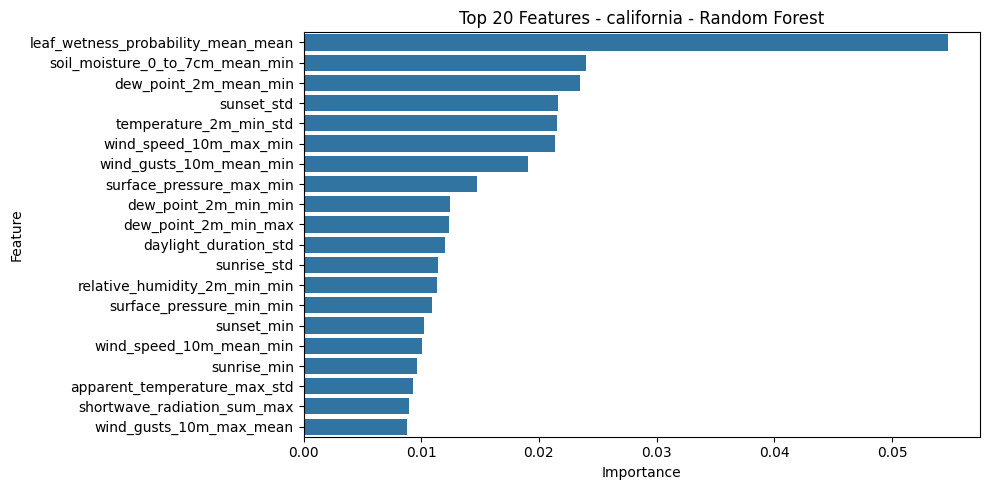

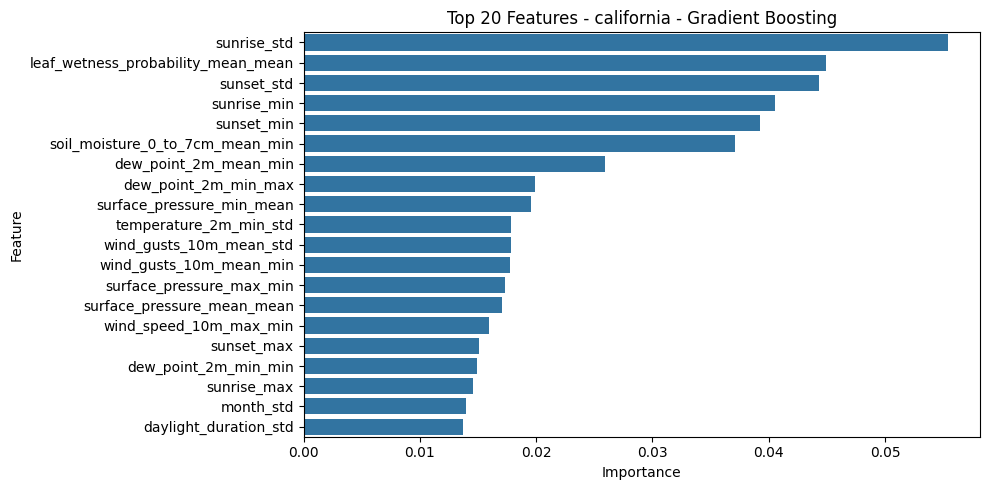

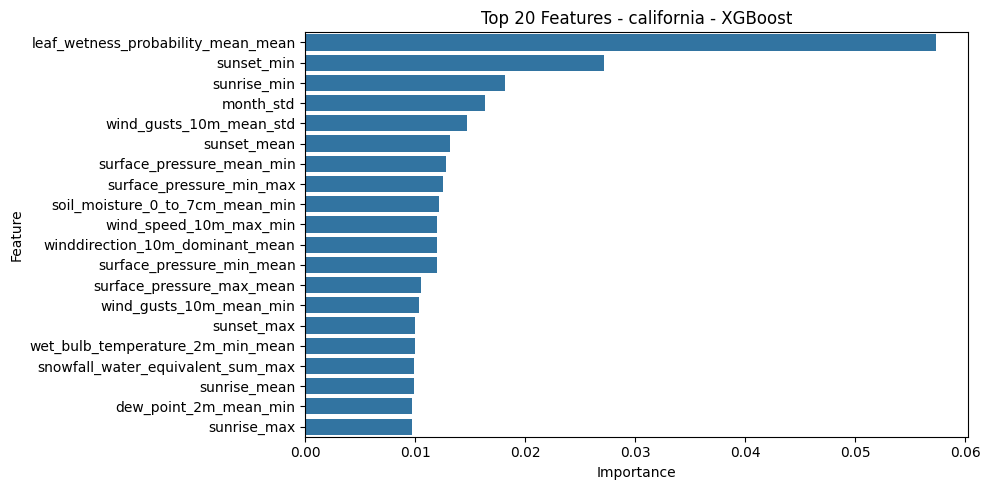

Training models for canada (rows: 12160)


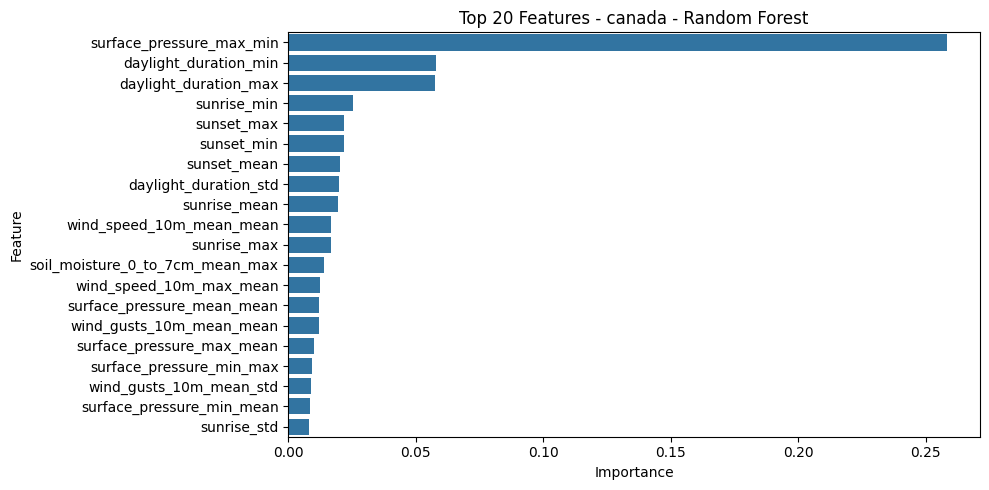

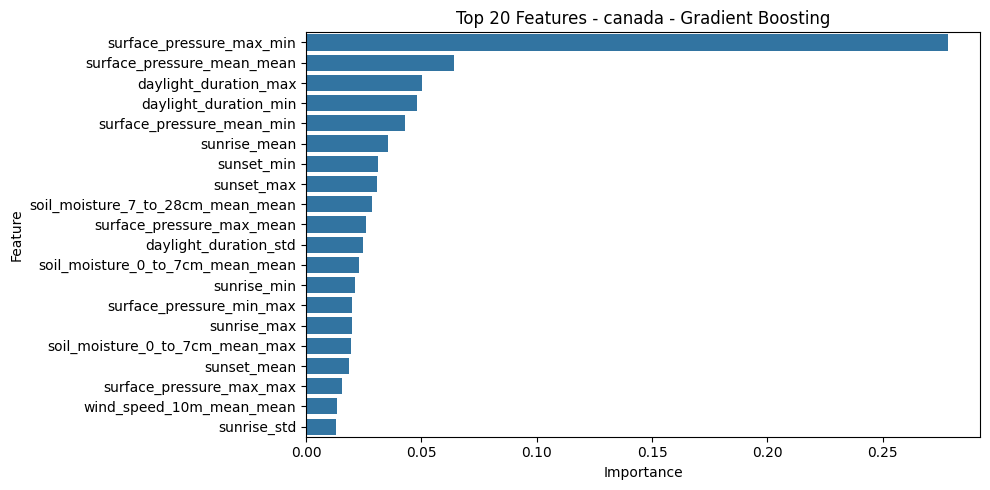

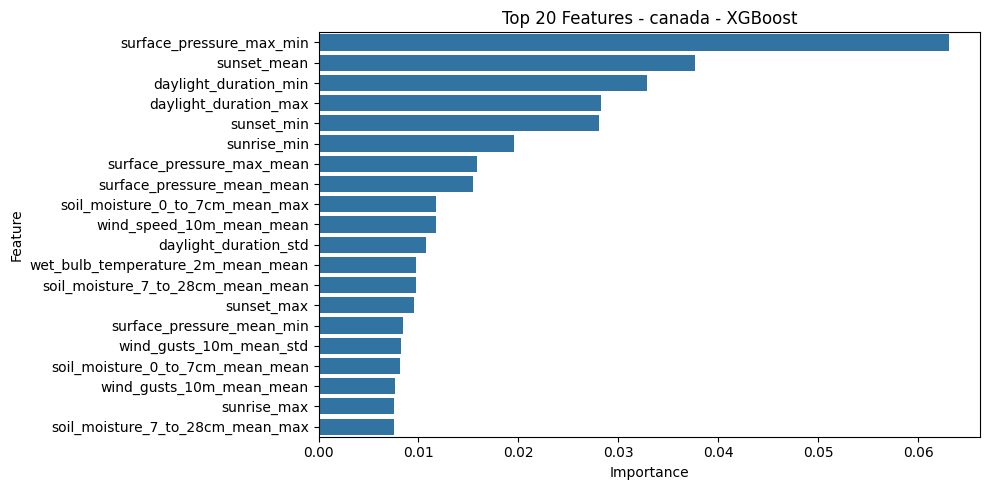

Training models for punjab (rows: 11604)


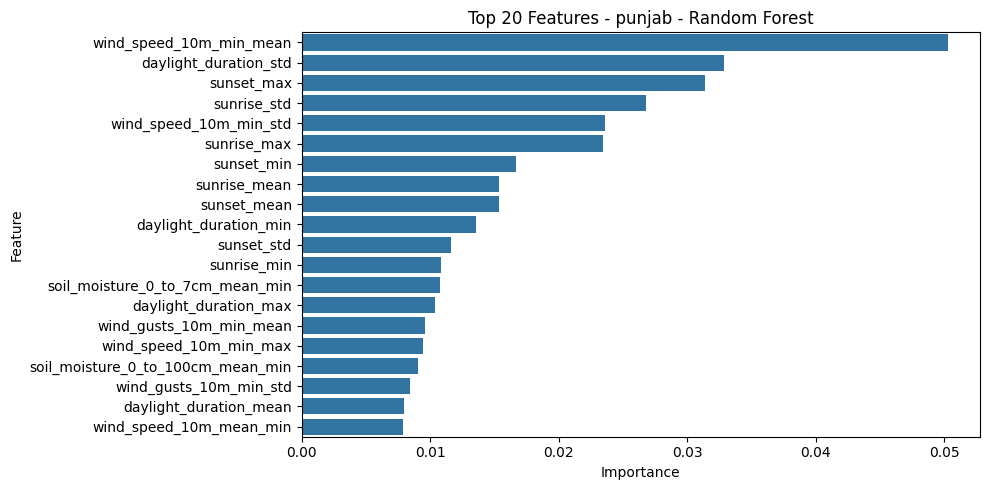

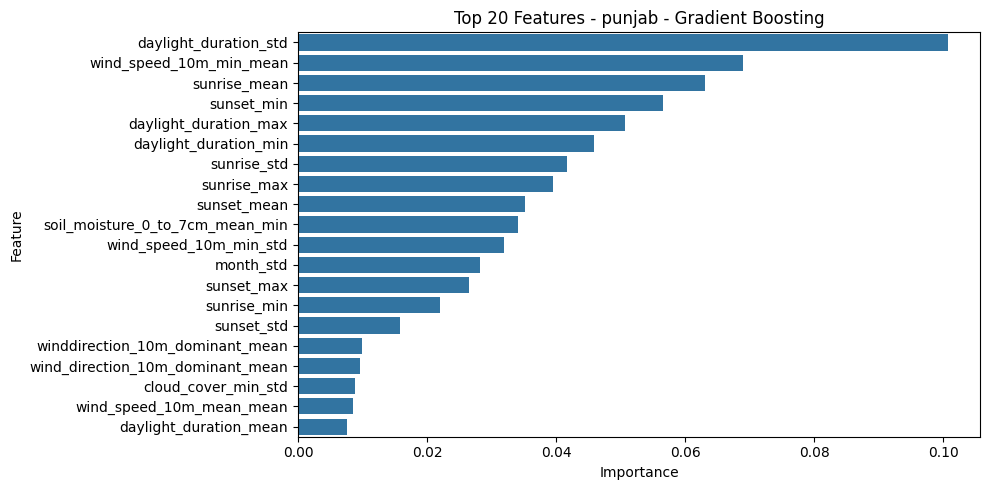

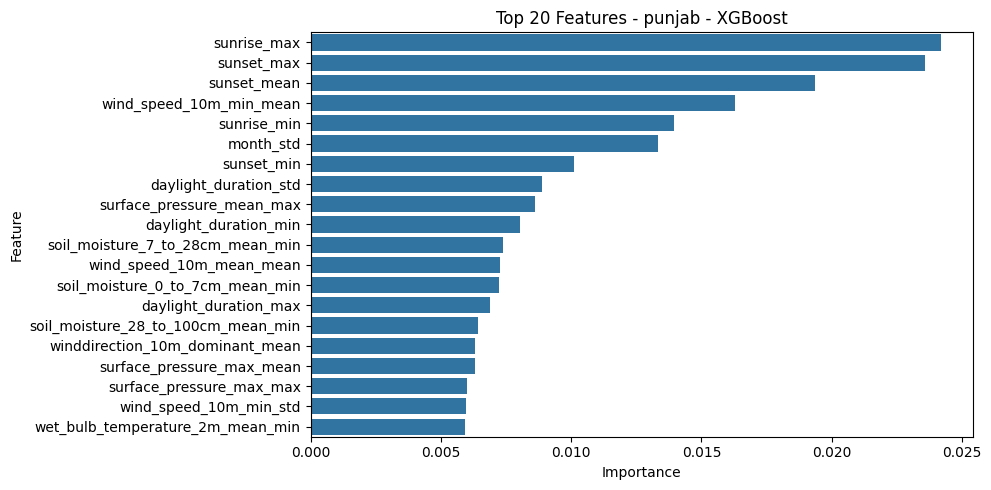


Final Results:
        Region              Model       RMSE        MAE         R2
0   california  Linear Regression  95.598410  21.675267 -17.141254
1   california   Ridge Regression  19.332692  14.639968   0.258091
2   california   Lasso Regression  19.369808  14.768867   0.255240
3   california      Random Forest  18.585578  13.392712   0.314325
4   california  Gradient Boosting  16.923823  12.230789   0.431458
5   california            XGBoost  17.353866  12.508028   0.402197
6       canada  Linear Regression   1.608544   1.201596   0.290546
7       canada   Ridge Regression   1.603673   1.200073   0.294836
8       canada   Lasso Regression   1.615252   1.207046   0.284616
9       canada      Random Forest   1.771877   1.306669   0.139154
10      canada  Gradient Boosting   1.648174   1.212921   0.255157
11      canada            XGBoost   1.776210   1.301540   0.134938
12      punjab  Linear Regression   1.535521   1.383821   0.041303
13      punjab   Ridge Regression   1.537779  

In [ ]:
base_path = '/content/drive/MyDrive/CropYield_MRP'
data_path = f'{base_path}/data'
model_path = f'{base_path}/models'
os.makedirs(model_path, exist_ok=True)

file_path = f'{data_path}/seasonal_enriched.csv'
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower()

target = 'yield_mean_t_ha'
df = df.dropna(subset=[target])

punjab_df = df[df['source_region'].str.lower() == 'punjab']
crop_stats = punjab_df.groupby('crop')[target].agg(['count','std']).reset_index()
filtered_crops = crop_stats[(crop_stats['count'] >= 5) & (crop_stats['std'] < 10)]['crop']
punjab_top20 = (
    punjab_df[punjab_df['crop'].isin(filtered_crops)]
    .groupby('crop').size()
    .sort_values(ascending=False)
    .head(20)
    .index.tolist()
)

regions = ['california','canada','punjab']
all_results = []

for reg in regions:
    region_df = df[df['source_region'].str.lower() == reg].copy()
    if reg == 'punjab':
        region_df = region_df[region_df['crop'].isin(punjab_top20)]

    print(f"Training models for {reg} (rows: {len(region_df)})")
    if len(region_df) < 50:
        print(f"Skipping {reg}, not enough data")
        continue

    leakage_cols = [c for c in region_df.columns if c.startswith('yield_') or c.startswith('production') or c.startswith('area')]
    X = region_df.drop(columns=leakage_cols + ['source_region','region','crop'], errors='ignore')
    y = region_df[target]

    categorical_cols = ['season'] if 'season' in X.columns else []
    numeric_cols = X.select_dtypes(include='number').columns.drop(['year'], errors='ignore')

    nan_cols = [c for c in numeric_cols if X[c].isna().all()]
    if nan_cols:
        X = X.drop(columns=nan_cols)
        numeric_cols = [c for c in numeric_cols if c not in nan_cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    num_imputer = SimpleImputer(strategy='mean')
    X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

    for col in categorical_cols:
        X_train[col] = X_train[col].fillna('missing')
        X_test[col] = X_test[col].fillna('missing')

    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)

    if categorical_cols:
        enc = preprocessor.named_transformers_['cat']
        cat_feats = enc.get_feature_names_out(categorical_cols)
        feature_names = list(numeric_cols) + list(cat_feats)
    else:
        feature_names = list(numeric_cols)

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.01, max_iter=10000),
        'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8,
                                 subsample=0.8, colsample_bytree=0.8,
                                 tree_method='hist', random_state=42)
    }

    for mdl_name, mdl in models.items():
        mdl.fit(X_train_prep, y_train)
        preds = mdl.predict(X_test_prep)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        all_results.append({
            'Region': reg,
            'Model': mdl_name,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

        joblib.dump(mdl, f"{model_path}/exp9_{reg}_{mdl_name.replace(' ', '')}.pkl")

        if hasattr(mdl, "feature_importances_"):
            fi = pd.DataFrame({
                'Feature': feature_names[:len(mdl.feature_importances_)],
                'Importance': mdl.feature_importances_
            }).sort_values(by='Importance', ascending=False).head(20)
            plt.figure(figsize=(10,5))
            sns.barplot(x='Importance', y='Feature', data=fi)
            plt.title(f"Top 20 Features - {reg} - {mdl_name}")
            plt.tight_layout()
            plt.show()

results_df = pd.DataFrame(all_results)
print("\nFinal Results:")
print(results_df)

best_models = results_df.loc[results_df.groupby('Region')['R2'].idxmax()]
print("\nBest models per region:")
print(best_models)

# experiment 10


Top 50% Selected Features:
['surface_pressure_mean_min', 'month_std', 'precipitation_hours_std', 'surface_pressure_min_mean', 'soil_moisture_0_to_7cm_mean_min', 'wind_speed_10m_mean_min', 'surface_pressure_max_min', 'pressure_msl_mean_min', 'soil_moisture_0_to_7cm_mean_std', 'surface_pressure_min_min', 'surface_pressure_max_mean', 'surface_pressure_mean_mean', 'dew_point_2m_min_max', 'wet_bulb_temperature_2m_mean_mean', 'wind_speed_10m_mean_mean', 'soil_moisture_0_to_100cm_mean_min', 'shortwave_radiation_sum_mean', 'surface_pressure_min_max', 'relative_humidity_2m_mean_min', 'wind_speed_10m_max_min', 'dew_point_2m_mean_min', 'dew_point_2m_max_mean', 'sunset_max', 'soil_moisture_28_to_100cm_mean_min', 'dew_point_2m_mean_mean', 'surface_pressure_max_max', 'soil_moisture_7_to_28cm_mean_min', 'sunrise_min', 'cloud_cover_mean_std', 'sunrise_max', 'sunset_min', 'wind_gusts_10m_max_std', 'wet_bulb_temperature_2m_mean_max', 'sunset_std', 'sunset_mean', 'wet_bulb_temperature_2m_min_max', 'dayl

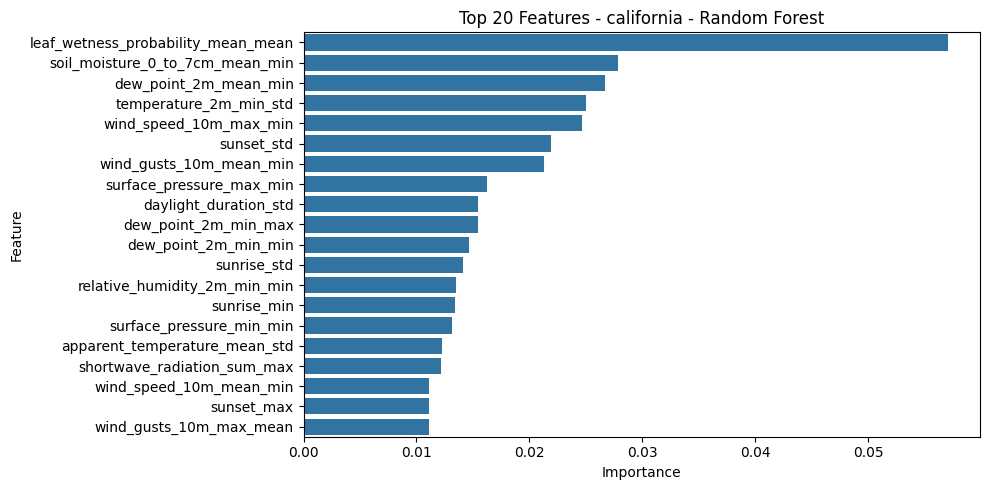

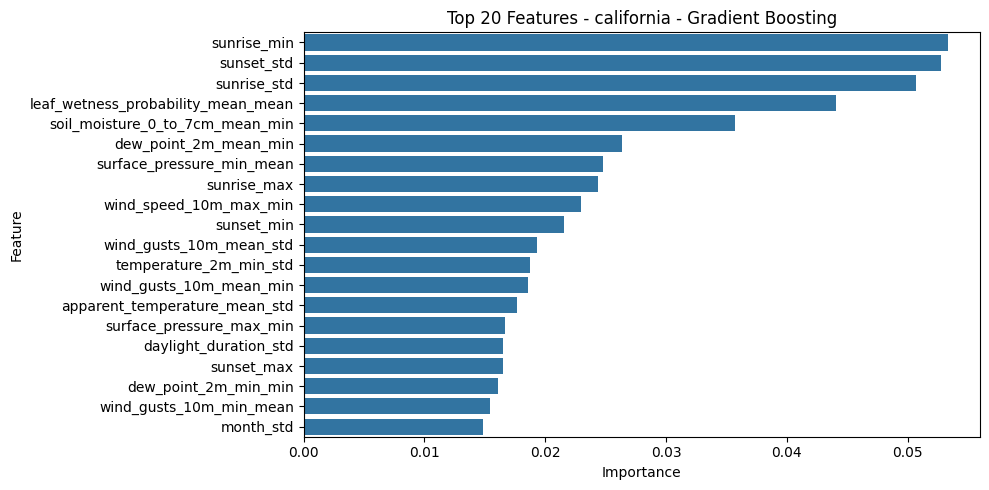

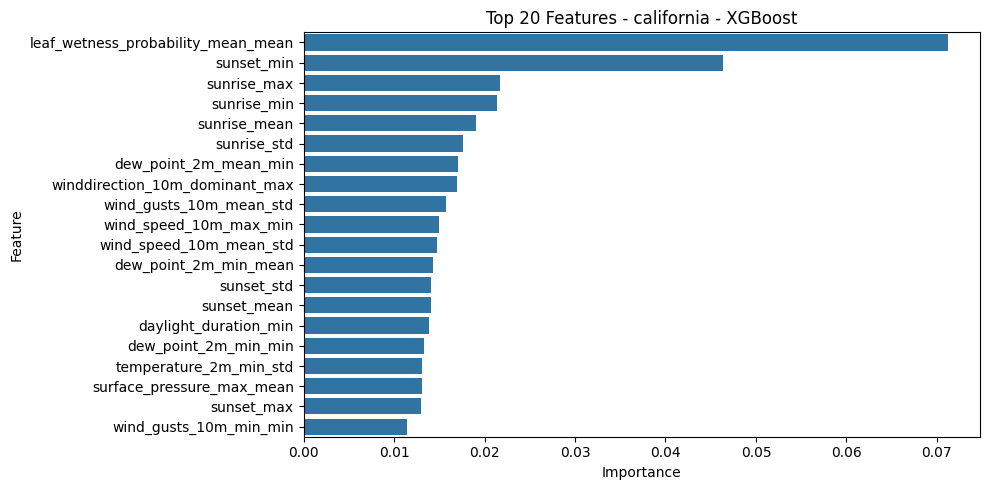


Training models for canada (rows: 12160)


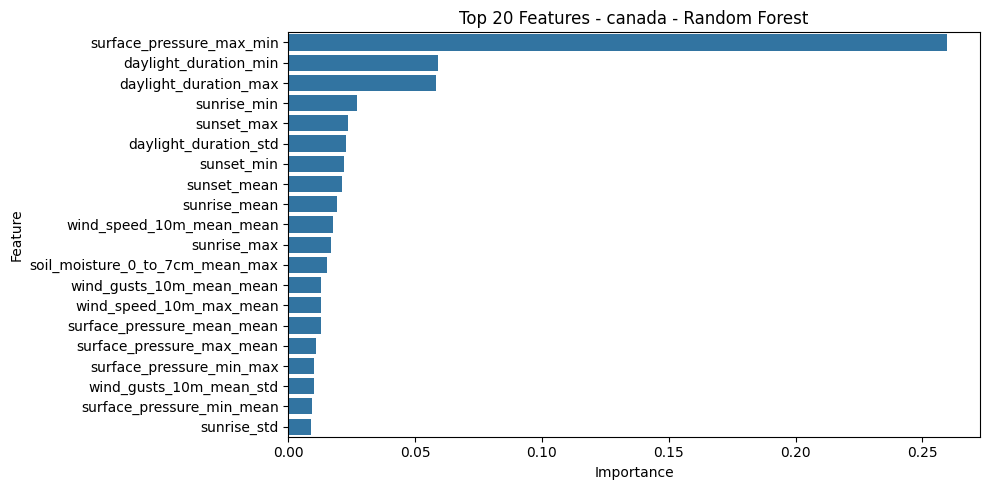

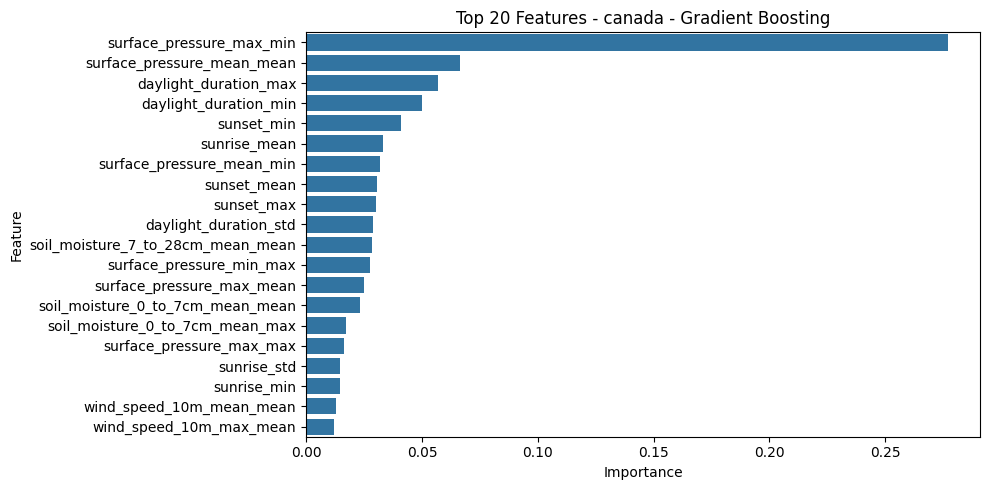

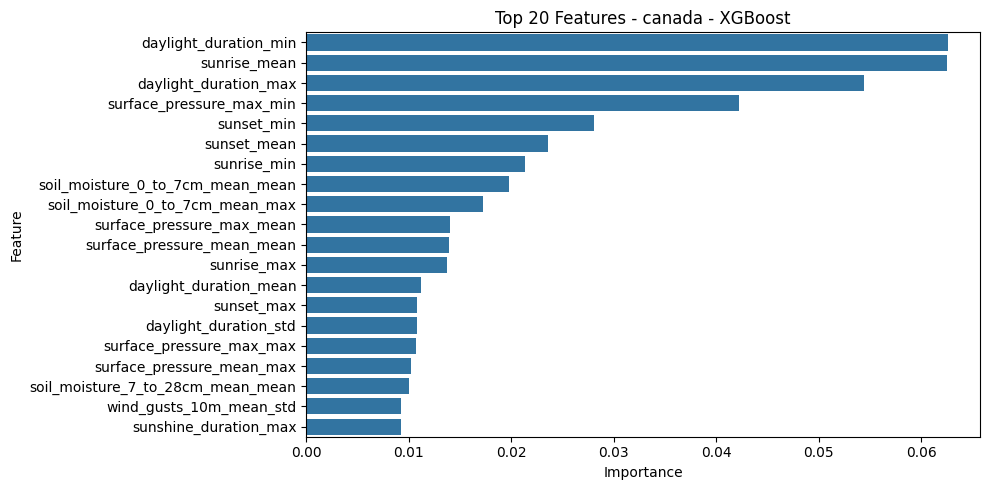


Training models for punjab (rows: 12512)


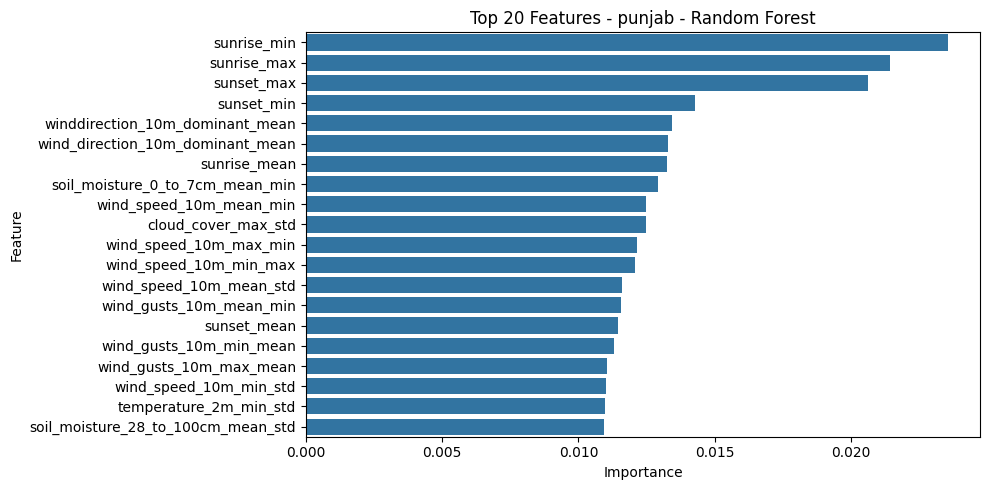

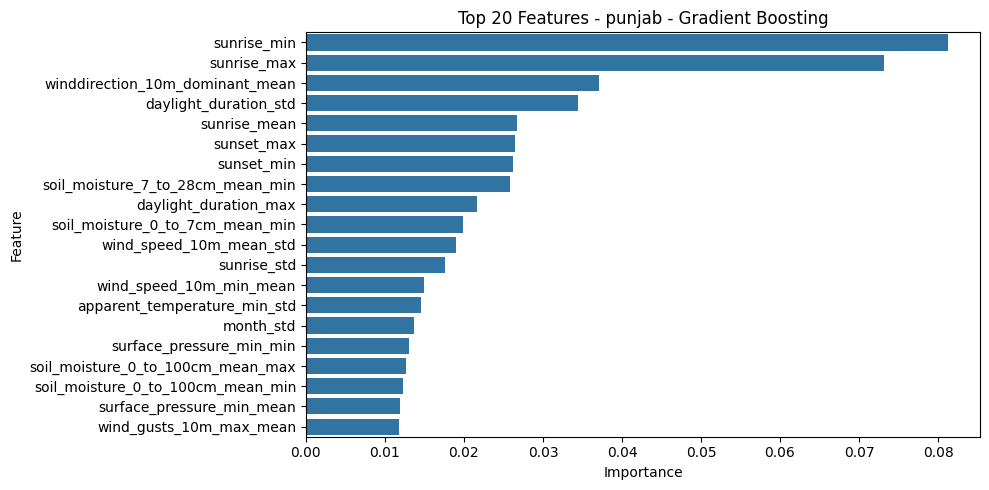

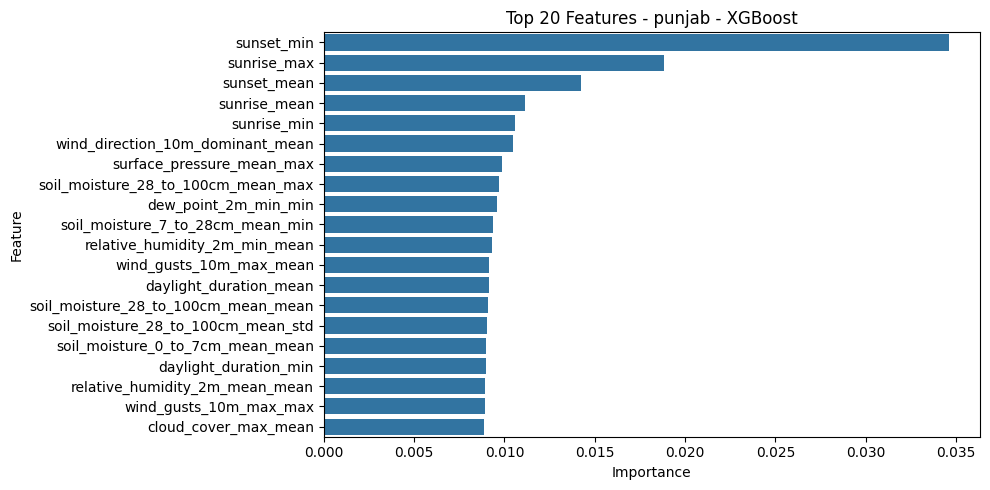


Final Results (Experiment 10 with reduced features):
        Region              Model       RMSE        MAE        R2
0   california  Linear Regression  20.178775  15.192914  0.191732
1   california   Ridge Regression  19.789912  14.701593  0.222584
2   california   Lasso Regression  19.880789  14.848670  0.215427
3   california      Random Forest  18.502987  13.347061  0.320406
4   california  Gradient Boosting  17.074201  12.370883  0.421309
5   california            XGBoost  17.339794  12.494061  0.403166
6       canada  Linear Regression   1.608076   1.205002  0.290958
7       canada   Ridge Regression   1.605770   1.204497  0.292990
8       canada   Lasso Regression   1.618245   1.210124  0.281963
9       canada      Random Forest   1.772622   1.307274  0.138430
10      canada  Gradient Boosting   1.647751   1.213436  0.255540
11      canada            XGBoost   1.776139   1.303439  0.135008
12      punjab  Linear Regression   4.751461   2.794616  0.001656
13      punjab   Ridge

In [ ]:
base_path = '/content/drive/MyDrive/CropYield_MRP'
data_path = f'{base_path}/data'
model_path = f'{base_path}/models'
os.makedirs(model_path, exist_ok=True)

df = pd.read_csv(f'{data_path}/seasonal_enriched.csv')
df.columns = df.columns.str.lower()

target = 'yield_mean_t_ha'
df = df.dropna(subset=[target])

df['city'] = df['region'].str.extract(r'(^[A-Z\s]+), PUNJAB', expand=False)

punjab_df = df[df['source_region'].str.lower() == 'punjab']
crop_var = punjab_df.groupby('crop')[target].std().reset_index()
valid_crops = crop_var[crop_var[target] < 25]['crop'].tolist()
punjab_filtered = punjab_df[punjab_df['crop'].isin(valid_crops)].copy()
punjab_filtered[target] = punjab_filtered[target].clip(upper=20)

df_filtered = pd.concat([
    df[df['source_region'].str.lower() != 'punjab'],
    punjab_filtered
])

drop_cols = ['source_region', 'region', 'crop', 'city', 'season', 'year']
weather_cols = [c for c in df_filtered.columns if c not in drop_cols + [target]
                and not c.startswith('yield_') and not c.startswith('production') and not c.startswith('area')]

X_all = df_filtered[weather_cols].copy()
X_all = X_all.fillna(X_all.mean())
y_all = df_filtered[target]

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_all, y_all)

feat_imp = pd.Series(rf.feature_importances_, index=weather_cols).sort_values(ascending=False)
top_features = feat_imp.head(len(feat_imp)//2).index.tolist()

print("\nTop 50% Selected Features:")
print(top_features)

regions = ['california','canada','punjab']
all_results = []

for reg in regions:
    region_df = df_filtered[df_filtered['source_region'].str.lower() == reg].copy()
    print(f"\nTraining models for {reg} (rows: {len(region_df)})")
    if len(region_df) < 50:
        print(f"Skipping {reg}, not enough data")
        continue

    X = region_df[top_features + (['season'] if 'season' in region_df.columns else [])].copy()
    y = region_df[target]

    categorical_cols = ['season'] if 'season' in X.columns else []
    numeric_cols = [c for c in top_features if c in X.columns]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    num_imputer = SimpleImputer(strategy='mean')
    X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

    for col in categorical_cols:
        X_train[col] = X_train[col].fillna('missing')
        X_test[col] = X_test[col].fillna('missing')

    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)

    feature_names = numeric_cols
    if categorical_cols:
        cat_feats = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
        feature_names += list(cat_feats)

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.01, max_iter=10000),
        'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8,
                                 subsample=0.8, colsample_bytree=0.8,
                                 tree_method='hist', random_state=42)
    }

    for mdl_name, mdl in models.items():
        mdl.fit(X_train_prep, y_train)
        preds = mdl.predict(X_test_prep)

        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        all_results.append({
            'Region': reg,
            'Model': mdl_name,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

        joblib.dump(mdl, f"{model_path}/exp10_reduced_{reg}_{mdl_name.replace(' ', '')}.pkl")

        if hasattr(mdl, "feature_importances_"):
            fi = pd.DataFrame({
                'Feature': feature_names[:len(mdl.feature_importances_)],
                'Importance': mdl.feature_importances_
            }).sort_values(by='Importance', ascending=False).head(20)
            plt.figure(figsize=(10,5))
            sns.barplot(x='Importance', y='Feature', data=fi)
            plt.title(f"Top 20 Features - {reg} - {mdl_name}")
            plt.tight_layout()
            plt.show()

results_df = pd.DataFrame(all_results)
print("\nFinal Results (Experiment 10 with reduced features):")
print(results_df)

best_models = results_df.loc[results_df.groupby('Region')['R2'].idxmax()]
print("\nBest models per region (R²):")
print(best_models)

experiment 11


Top features used for Punjab Rice: 128 selected


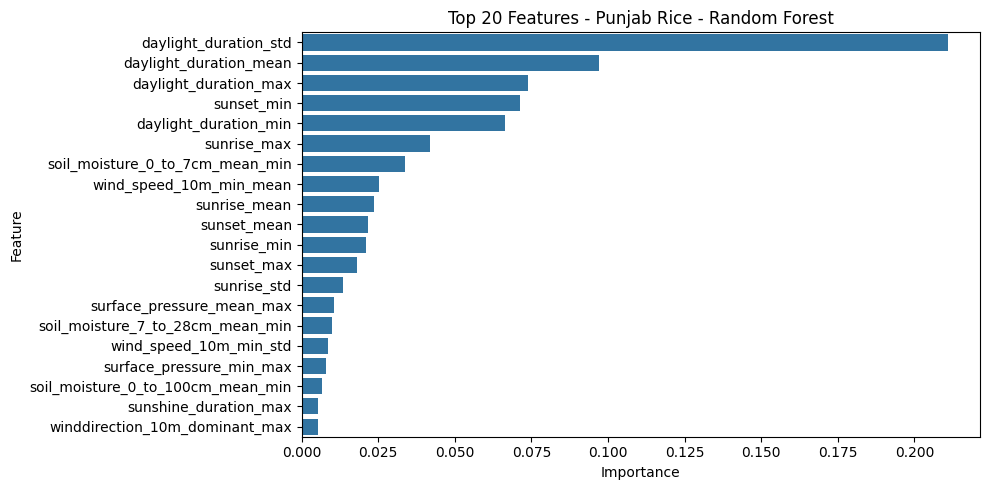

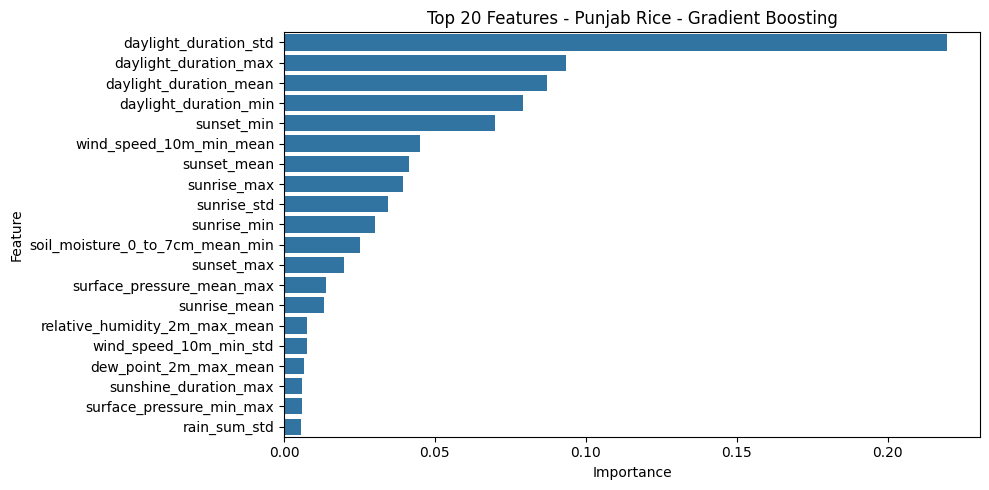

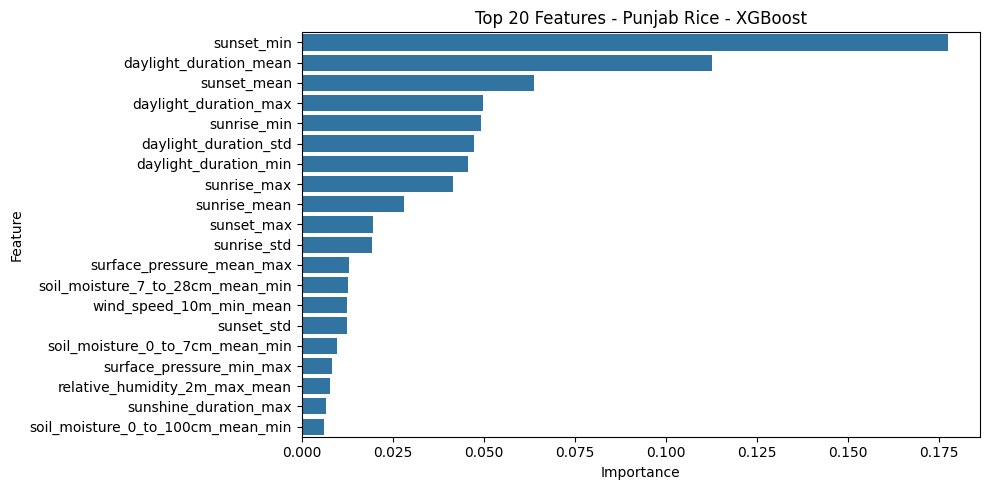


Final Results (Experiment 11 - Punjab Rice only):
          Region              Model      RMSE       MAE        R2
0  Punjab - Rice  Linear Regression  0.373145  0.290957  0.575943
1  Punjab - Rice   Ridge Regression  0.394498  0.303619  0.526020
2  Punjab - Rice   Lasso Regression  0.424537  0.335957  0.451091
3  Punjab - Rice      Random Forest  0.272467  0.200331  0.773902
4  Punjab - Rice  Gradient Boosting  0.267593  0.194422  0.781919
5  Punjab - Rice            XGBoost  0.271328  0.201919  0.775789

Best model for Punjab Rice:
Region        Punjab - Rice
Model     Gradient Boosting
RMSE               0.267593
MAE                0.194422
R2                 0.781919
Name: 4, dtype: object


In [ ]:
base_path = '/content/drive/MyDrive/CropYield_MRP'
data_path = f'{base_path}/data'
model_path = f'{base_path}/models'
os.makedirs(model_path, exist_ok=True)

df = pd.read_csv(f'{data_path}/seasonal_enriched.csv')
df.columns = df.columns.str.lower()

target = 'yield_mean_t_ha'
df = df.dropna(subset=[target])

punjab_rice = df[(df['source_region'].str.lower() == 'punjab') &
                 (df['crop'].str.lower() == 'rice')].copy()

#clip extreme yields at 20 t/ha
punjab_rice[target] = punjab_rice[target].clip(upper=20)

drop_cols = ['source_region', 'region', 'crop', 'city', 'season', 'year']
weather_cols = [c for c in df.columns if c not in drop_cols + [target]
                and not c.startswith('yield_') and not c.startswith('production') and not c.startswith('area')]

X_all = df[weather_cols].fillna(df[weather_cols].mean())
y_all = df[target]

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_all, y_all)

feat_imp = pd.Series(rf.feature_importances_, index=weather_cols).sort_values(ascending=False)
top_features = feat_imp.head(len(feat_imp)//2).index.tolist()

print(f"\nTop features used for Punjab Rice: {len(top_features)} selected")

X = punjab_rice[top_features + (['season'] if 'season' in punjab_rice.columns else [])].copy()
y = punjab_rice[target]

categorical_cols = ['season'] if 'season' in X.columns else []
numeric_cols = [c for c in top_features if c in X.columns]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

num_imputer = SimpleImputer(strategy='mean')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

for col in categorical_cols:
    X_train[col] = X_train[col].fillna('missing')
    X_test[col] = X_test[col].fillna('missing')

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

feature_names = numeric_cols
if categorical_cols:
    cat_feats = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names += list(cat_feats)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8,
                             subsample=0.8, colsample_bytree=0.8,
                             tree_method='hist', random_state=42)
}

all_results = []

for mdl_name, mdl in models.items():
    mdl.fit(X_train_prep, y_train)
    preds = mdl.predict(X_test_prep)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    all_results.append({
        'Region': 'Punjab - Rice',
        'Model': mdl_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

    joblib.dump(mdl, f"{model_path}/exp11_punjab_rice_{mdl_name.replace(' ', '')}.pkl")

    if hasattr(mdl, "feature_importances_"):
        fi = pd.DataFrame({
            'Feature': feature_names[:len(mdl.feature_importances_)],
            'Importance': mdl.feature_importances_
        }).sort_values(by='Importance', ascending=False).head(20)
        plt.figure(figsize=(10,5))
        sns.barplot(x='Importance', y='Feature', data=fi)
        plt.title(f"Top 20 Features - Punjab Rice - {mdl_name}")
        plt.tight_layout()
        plt.show()

results_df = pd.DataFrame(all_results)
print("\nFinal Results (Experiment 11 - Punjab Rice only):")
print(results_df)

best_model = results_df.loc[results_df['R2'].idxmax()]
print("\nBest model for Punjab Rice:")
print(best_model)

# exerimetn 12

In [ ]:
base_path = '/content/drive/MyDrive/CropYield_MRP'
data_path = f'{base_path}/data'
model_path = f'{base_path}/models'
os.makedirs(model_path, exist_ok=True)

df = pd.read_csv(f'{data_path}/seasonal_enriched.csv')
df.columns = df.columns.str.lower()
target = 'yield_mean_t_ha'
df = df.dropna(subset=[target])

drop_cols = ['source_region','region','crop','city','season','year']
weather_cols = [c for c in df.columns if c not in drop_cols+[target]
                and not c.startswith('yield_') and not c.startswith('production') and not c.startswith('area')]

top_crops = (
    df.groupby(['source_region','crop']).size().reset_index(name='count')
      .sort_values(['source_region','count'], ascending=[True,False])
      .groupby('source_region').head(5)
)
region_crops = top_crops.groupby('source_region')['crop'].apply(list).to_dict()

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8,
                             subsample=0.8, colsample_bytree=0.8,
                             tree_method='hist', random_state=42)
}

all_results = []

for region, crops in region_crops.items():
    for crop in crops:
        df_sub = df[(df['source_region'].str.lower() == region.lower()) &
                    (df['crop'].str.lower() == crop.lower())].copy()
        if len(df_sub) < 50:
            continue
        if region.lower() == 'punjab':
            df_sub[target] = df_sub[target].clip(upper=20)
        X = df_sub[weather_cols + (['season'] if 'season' in df_sub.columns else [])].copy()
        y = df_sub[target]
        categorical_cols = ['season'] if 'season' in X.columns else []
        numeric_cols = [c for c in weather_cols if c in X.columns]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        numeric_cols = [c for c in numeric_cols if c in X_train.columns and X_train[c].notna().any()]
        num_imputer = SimpleImputer(strategy='mean')
        X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
        X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])
        for col in categorical_cols:
            X_train[col] = X_train[col].fillna('missing')
            X_test[col] = X_test[col].fillna('missing')
        preprocessor = ColumnTransformer(transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])
        X_train_prep = preprocessor.fit_transform(X_train)
        X_test_prep = preprocessor.transform(X_test)
        for mdl_name, mdl in models.items():
            mdl.fit(X_train_prep, y_train)
            preds = mdl.predict(X_test_prep)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)
            r2 = r2_score(y_test, preds)
            all_results.append({
                'Region': region,
                'Crop': crop,
                'Model': mdl_name,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })
            model_filename = f"{model_path}/exp12_{region}_{crop}_{mdl_name.replace(' ', '')}.pkl"
            joblib.dump(mdl, model_filename)

results_df = pd.DataFrame(all_results)
results_csv = f"{model_path}/exp12_results.csv"
results_df.to_csv(results_csv, index=False)

print("\nFinal Results (Experiment 12 - All Features):")
print(results_df.sort_values(['Region','Crop','R2'], ascending=[True,True,False]).head(50))

best_models = results_df.loc[results_df.groupby(['Region','Crop'])['R2'].idxmax()]
print("\nBest models per crop per region:")
print(best_models.sort_values(['Region','R2'], ascending=[True,False]))
best_models_csv = f"{model_path}/exp12_best_models.csv"
best_models.to_csv(best_models_csv, index=False)


Final Results (Experiment 12 - All Features):
        Region               Crop              Model       RMSE        MAE  \
4   california             BARLEY  Gradient Boosting  16.923823  12.230789   
5   california             BARLEY            XGBoost  17.353866  12.508028   
3   california             BARLEY      Random Forest  18.585578  13.392712   
1   california             BARLEY   Ridge Regression  19.332692  14.639968   
2   california             BARLEY   Lasso Regression  19.369808  14.768867   
0   california             BARLEY  Linear Regression  95.598410  21.675267   
22      canada             Barley  Gradient Boosting   0.680029   0.505627   
23      canada             Barley            XGBoost   0.681852   0.505954   
21      canada             Barley      Random Forest   0.711948   0.534599   
19      canada             Barley   Ridge Regression   0.758282   0.574872   
20      canada             Barley   Lasso Regression   0.761373   0.574306   
18      canada   

# experiment 12b

In [ ]:
base_path = '/content/drive/MyDrive/CropYield_MRP'
data_path = f'{base_path}/data'
model_path = f'{base_path}/models'
os.makedirs(model_path, exist_ok=True)

df = pd.read_csv(f'{data_path}/seasonal_enriched.csv')
df.columns = df.columns.str.lower()
target = 'yield_mean_t_ha'
df = df.dropna(subset=[target])

drop_cols = ['source_region','region','crop','city','season','year']
weather_cols = [c for c in df.columns if c not in drop_cols+[target]
                and not c.startswith('yield_') and not c.startswith('production') and not c.startswith('area')]

X_all = df[weather_cols].fillna(df[weather_cols].mean())
y_all = df[target]
rf_global = RandomForestRegressor(n_estimators=200, random_state=42)
rf_global.fit(X_all, y_all)
feat_imp = pd.Series(rf_global.feature_importances_, index=weather_cols).sort_values(ascending=False)
top_features = feat_imp.head(len(feat_imp)//2).index.tolist()

top_crops = (
    df.groupby(['source_region','crop']).size().reset_index(name='count')
      .sort_values(['source_region','count'], ascending=[True,False])
      .groupby('source_region').head(5)
)
region_crops = top_crops.groupby('source_region')['crop'].apply(list).to_dict()

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8,
                             subsample=0.8, colsample_bytree=0.8,
                             tree_method='hist', random_state=42)
}

all_results = []

for region, crops in region_crops.items():
    for crop in crops:
        df_sub = df[(df['source_region'].str.lower() == region.lower()) &
                    (df['crop'].str.lower() == crop.lower())].copy()
        if len(df_sub) < 50:
            continue
        if region.lower() == 'punjab':
            df_sub[target] = df_sub[target].clip(upper=20)

        X = df_sub[top_features + (['season'] if 'season' in df_sub.columns else [])].copy()
        y = df_sub[target]
        categorical_cols = ['season'] if 'season' in X.columns else []
        numeric_cols = [c for c in top_features if c in X.columns]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        numeric_cols = [c for c in numeric_cols if c in X_train.columns and X_train[c].notna().any()]
        num_imputer = SimpleImputer(strategy='mean')
        X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
        X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])
        for col in categorical_cols:
            X_train[col] = X_train[col].fillna('missing')
            X_test[col] = X_test[col].fillna('missing')

        preprocessor = ColumnTransformer(transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])
        X_train_prep = preprocessor.fit_transform(X_train)
        X_test_prep = preprocessor.transform(X_test)

        for mdl_name, mdl in models.items():
            mdl.fit(X_train_prep, y_train)
            preds = mdl.predict(X_test_prep)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)
            r2 = r2_score(y_test, preds)
            all_results.append({
                'Region': region,
                'Crop': crop,
                'Model': mdl_name,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })
            model_filename = f"{model_path}/exp12b_{region}_{crop}_{mdl_name.replace(' ', '')}.pkl"
            joblib.dump(mdl, model_filename)

results_df = pd.DataFrame(all_results)
results_csv = f"{model_path}/exp12b_results.csv"
results_df.to_csv(results_csv, index=False)

print("\nFinal Results (Experiment 12b - Reduced Features):")
print(results_df.sort_values(['Region','Crop','R2'], ascending=[True,True,False]).head(50))

best_models = results_df.loc[results_df.groupby(['Region','Crop'])['R2'].idxmax()]
best_models_csv = f"{model_path}/exp12b_best_models.csv"
best_models.to_csv(best_models_csv, index=False)

print("\nBest models per crop per region:")
print(best_models.sort_values(['Region','R2'], ascending=[True,False]))


Final Results (Experiment 12b - Reduced Features):
        Region               Crop              Model       RMSE        MAE  \
4   california             BARLEY  Gradient Boosting  17.829461  12.928776   
5   california             BARLEY            XGBoost  17.990863  12.531389   
3   california             BARLEY      Random Forest  18.756625  13.374469   
1   california             BARLEY   Ridge Regression  19.655083  14.741449   
2   california             BARLEY   Lasso Regression  19.708352  14.854086   
0   california             BARLEY  Linear Regression  19.834696  15.029047   
23      canada             Barley            XGBoost   0.661689   0.492712   
22      canada             Barley  Gradient Boosting   0.686322   0.515853   
21      canada             Barley      Random Forest   0.701593   0.530139   
19      canada             Barley   Ridge Regression   0.748795   0.567332   
20      canada             Barley   Lasso Regression   0.759273   0.577138   
18      cana

# **Shap analysis**


>>> running SHAP for california - BARLEY


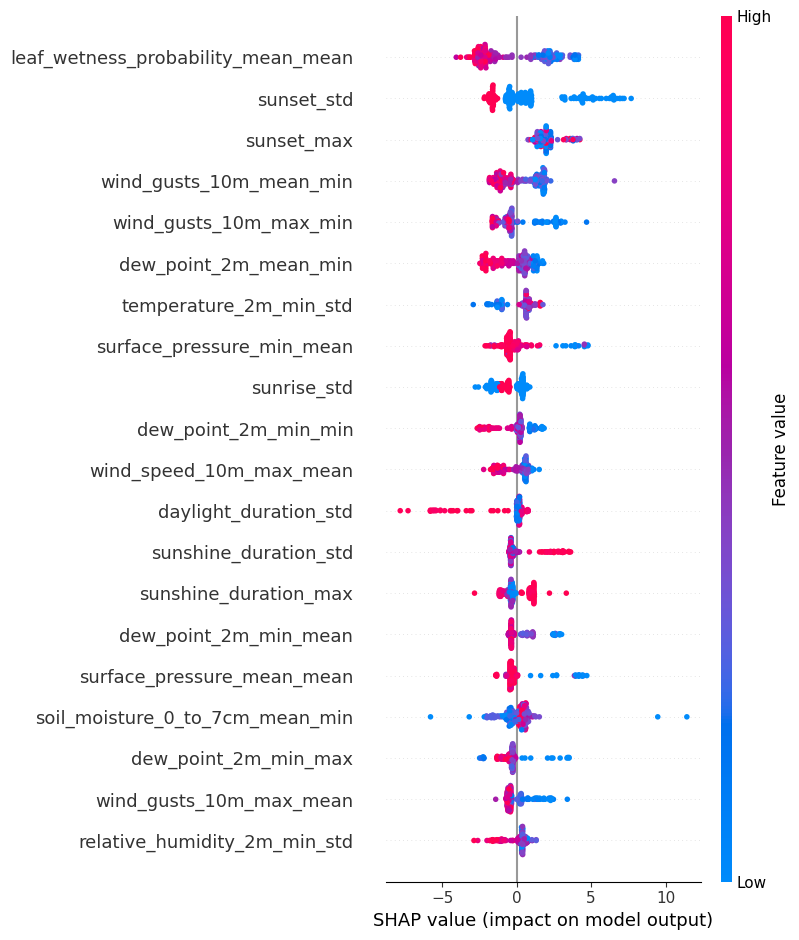

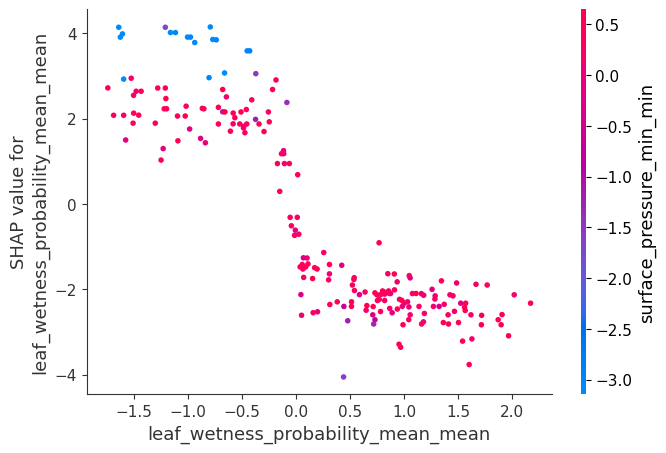


>>> running SHAP for canada - Wheat, all


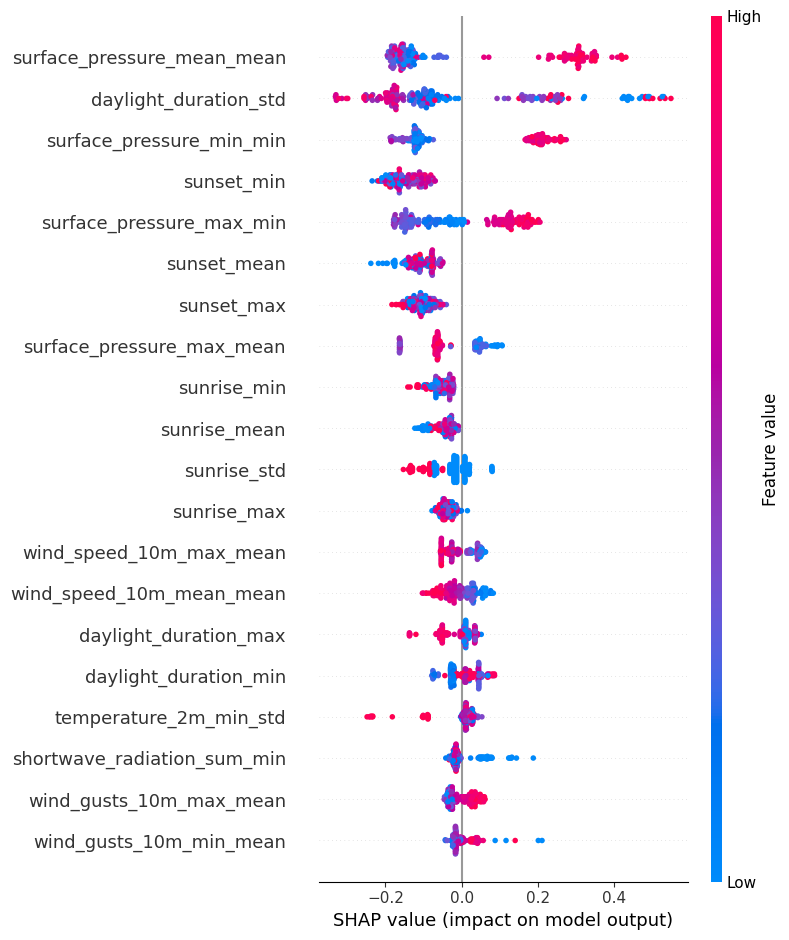

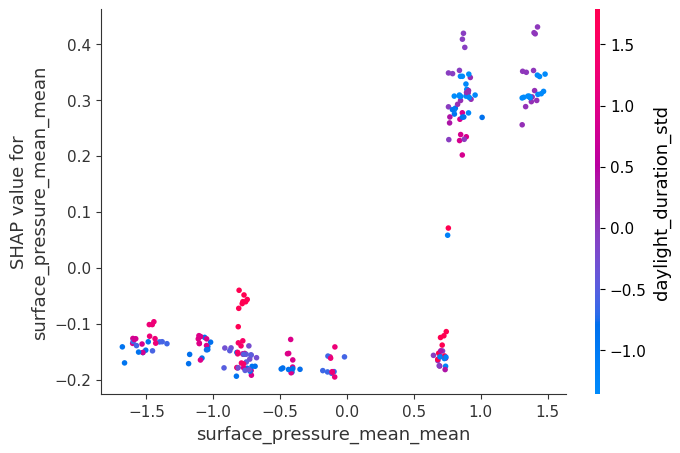


>>> running SHAP for canada - Wheat, spring


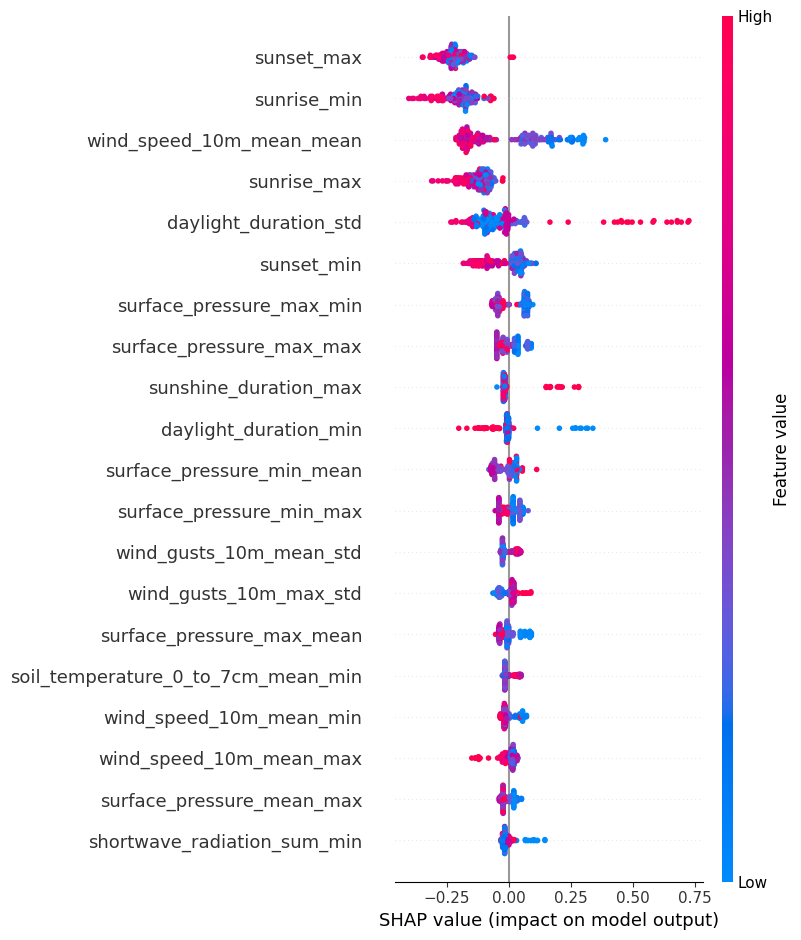

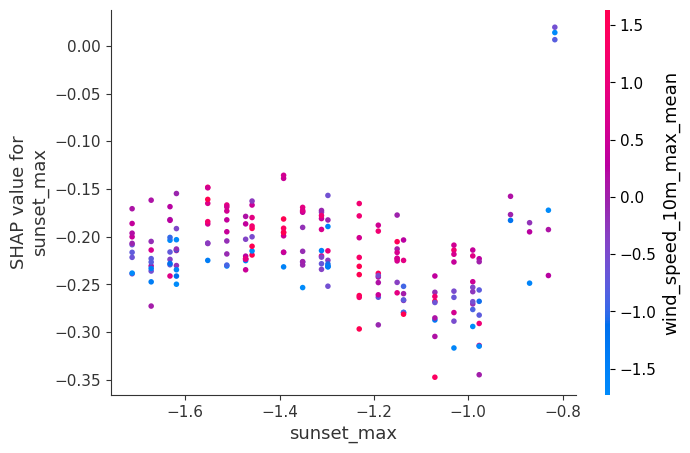


>>> running SHAP for canada - Canola


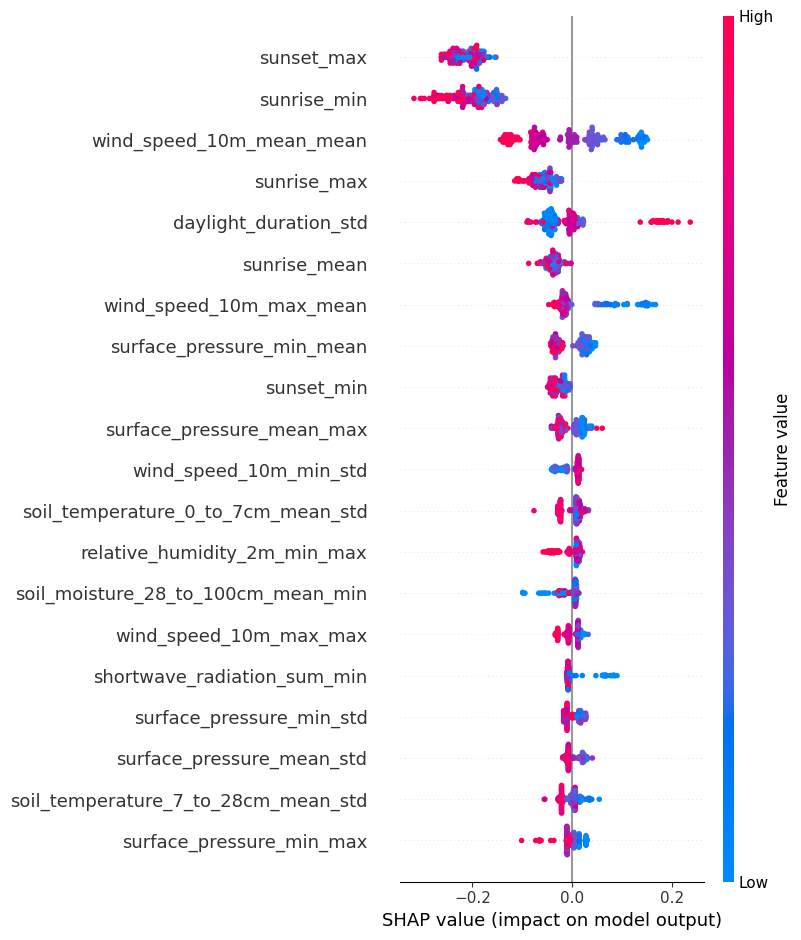

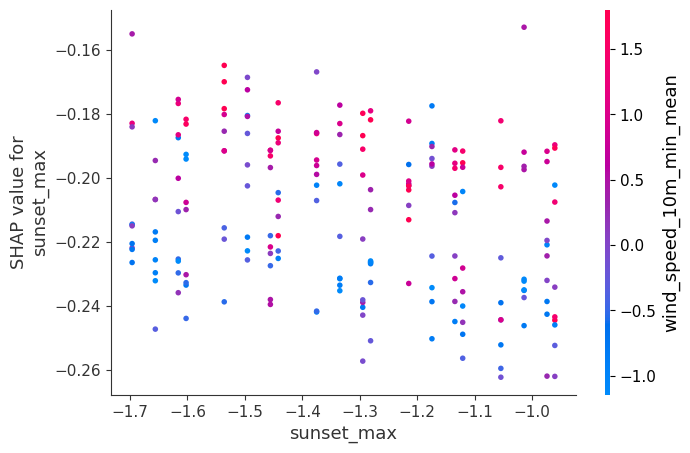


>>> running SHAP for punjab - Rice


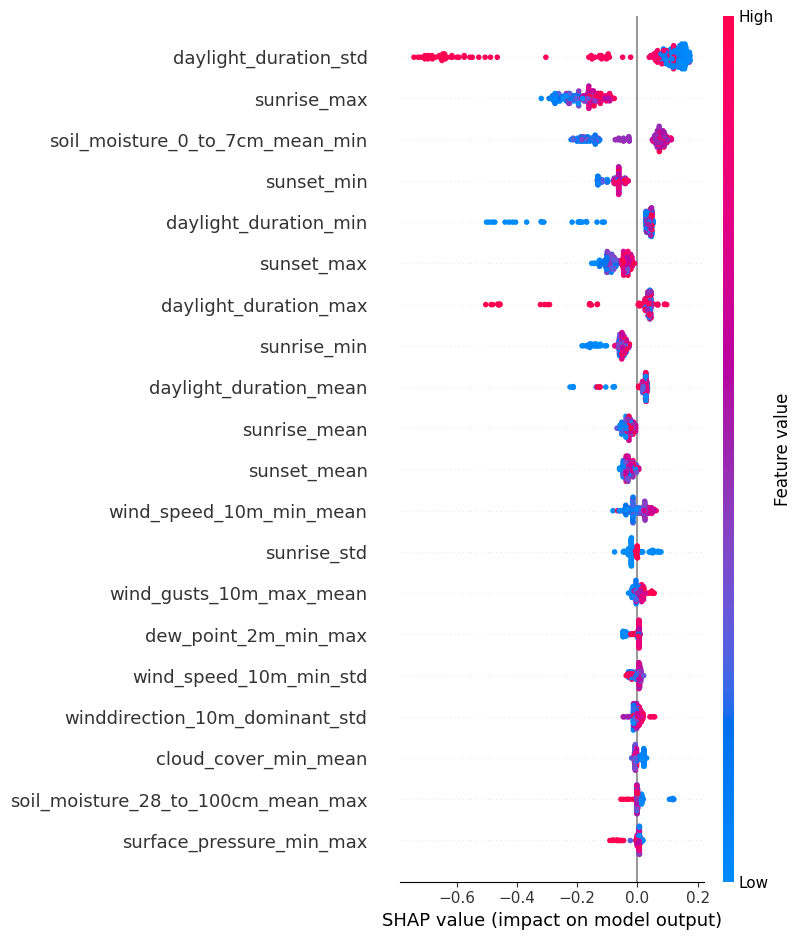

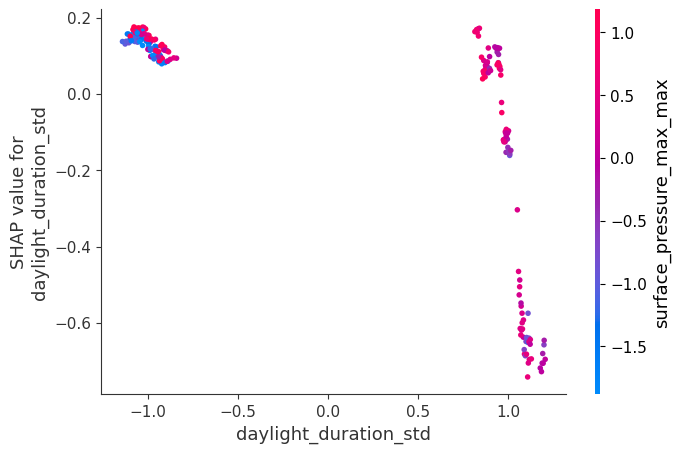


>>> running SHAP for punjab - Wheat


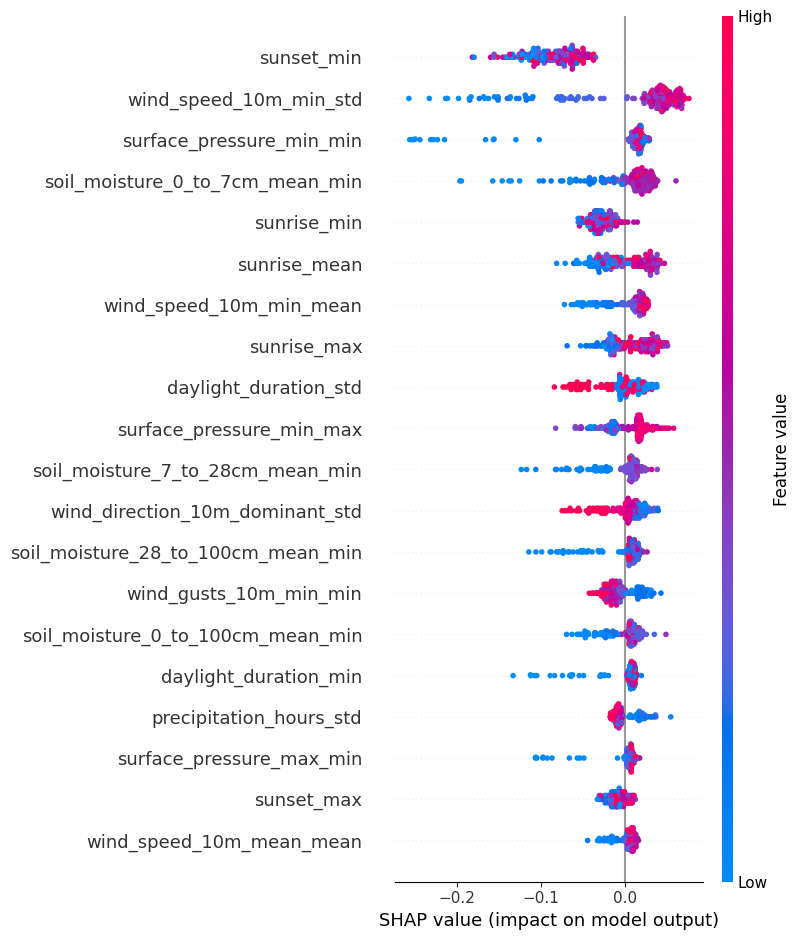

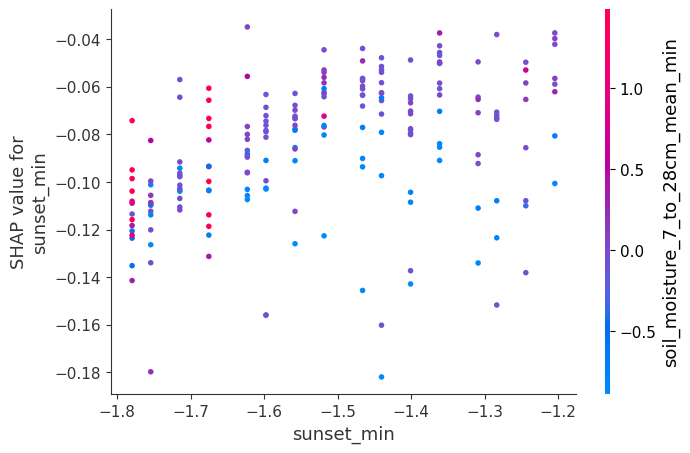

In [10]:
base_path = '/content/drive/MyDrive/CropYield_MRP'
data_path = f'{base_path}/data'
model_path = f'{base_path}/models'

df = pd.read_csv(f'{data_path}/seasonal_enriched.csv')
df.columns = df.columns.str.lower()
target = 'yield_mean_t_ha'
df = df.dropna(subset=[target])

def preprocess_data(region=None, crop=None, features=None, clip_punjab=True):
    subset = df.copy()
    if region:
        subset = subset[subset['source_region'].str.lower() == region.lower()]
    if crop:
        subset = subset[subset['crop'].str.lower() == crop.lower()]
    if clip_punjab and region and region.lower() == 'punjab':
        subset[target] = subset[target].clip(upper=20)

    skip_cols = ['source_region','region','crop','city','year']
    weather_cols = [c for c in subset.columns if c not in skip_cols+[target]
                    and not c.startswith('yield_') and not c.startswith('production') and not c.startswith('area')]
    if features is None:
        features = weather_cols + (['season'] if 'season' in subset.columns else [])
    #deduplicate
    features = list(dict.fromkeys(features))

    X = subset[features].copy()
    y = subset[target]

    categorical_cols = ['season'] if 'season' in X.columns else []
    numeric_cols = [c for c in features if c in X.columns and c != 'season']
    numeric_cols = list(dict.fromkeys(numeric_cols))

    nan_cols = [c for c in numeric_cols if X[c].isna().all()]
    if nan_cols:
        X = X.drop(columns=nan_cols)
        numeric_cols = [c for c in numeric_cols if c not in nan_cols]

    num_imputer = SimpleImputer(strategy='mean')
    X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])

    for col in categorical_cols:
        X[col] = X[col].fillna('missing')

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])
    X_prep = preprocessor.fit_transform(X)

    feature_names = numeric_cols
    if categorical_cols:
        cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
        feature_names += list(cat_names)

    return X_prep, y.values, feature_names

#models we want to explain
best_models_info = [
    ('california', 'BARLEY', 'exp12_california_BARLEY_GradientBoosting.pkl'),
    ('canada', 'Wheat, all', 'exp12_canada_Wheat, all_GradientBoosting.pkl'),
    ('canada', 'Wheat, spring', 'exp12_canada_Wheat, spring_GradientBoosting.pkl'),
    ('canada', 'Canola', 'exp12_canada_Canola_GradientBoosting.pkl'),
    ('punjab', 'Rice', 'exp12_punjab_Rice_GradientBoosting.pkl'),
    ('punjab', 'Wheat', 'exp12_punjab_Wheat_XGBoost.pkl')
]

#go through each model and make SHAP plots
for region, crop, model_file in best_models_info:
    file_path = os.path.join(model_path, model_file)
    if not os.path.exists(file_path):
        print(f"could not find model: {file_path}")
        continue

    print(f"\n>>> running SHAP for {region} - {crop}")

    #load model from disk
    model = joblib.load(file_path)

    #get the right subset of data for this crop and region
    X_prep, y, feature_names = preprocess_data(region=region, crop=crop)

    #pick the right explainer depending on the model
    if 'XGBoost' in model_file or 'GradientBoosting' in model_file:
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.Explainer(model.predict, X_prep)

    #compute SHAP values on a smaller sample for speed
    shap_values = explainer.shap_values(X_prep[:200])

    #show the global importance plot
    shap.summary_plot(shap_values, X_prep[:200], feature_names=feature_names, show=True)

    #show how the most important feature behaves
    top_feature = feature_names[np.argsort(np.abs(shap_values).mean(0))[-1]]
    shap.dependence_plot(top_feature, shap_values, X_prep[:200], feature_names=feature_names)

In [11]:
shap_output_dir = f"{model_path}/shap_plots"
os.makedirs(shap_output_dir, exist_ok=True)


def preprocess_data(region=None, crop=None, features=None, clip_punjab=True):
    subset = df.copy()
    if region:
        subset = subset[subset['source_region'].str.lower() == region.lower()]
    if crop:
        subset = subset[subset['crop'].str.lower() == crop.lower()]
    if clip_punjab and region and region.lower() == 'punjab':
        subset[target] = subset[target].clip(upper=20)

    skip_cols = ['source_region','region','crop','city','year']
    weather_cols = [c for c in subset.columns if c not in skip_cols+[target]
                    and not c.startswith('yield_') and not c.startswith('production') and not c.startswith('area')]
    if features is None:
        features = weather_cols + (['season'] if 'season' in subset.columns else [])
    features = list(dict.fromkeys(features))

    X = subset[features].copy()
    y = subset[target]

    categorical_cols = ['season'] if 'season' in X.columns else []
    numeric_cols = [c for c in features if c in X.columns and c != 'season']
    numeric_cols = list(dict.fromkeys(numeric_cols))

    nan_cols = [c for c in numeric_cols if X[c].isna().all()]
    if nan_cols:
        X = X.drop(columns=nan_cols)
        numeric_cols = [c for c in numeric_cols if c not in nan_cols]

    num_imputer = SimpleImputer(strategy='mean')
    X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])

    for col in categorical_cols:
        X[col] = X[col].fillna('missing')

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])
    X_prep = preprocessor.fit_transform(X)

    feature_names = numeric_cols
    if categorical_cols:
        cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
        feature_names += list(cat_names)

    return X_prep, y.values, feature_names

best_models_info = [
    ("california", "BARLEY", "GradientBoosting"),
    ("canada", "Wheat, all", "GradientBoosting"),
    ("punjab", "Rice", "GradientBoosting"),
    ("punjab", "Wheat", "XGBoost")
]

for region, crop, model_name in best_models_info:
    print(f">>> generating SHAP for {region} - {crop} ({model_name})")

    model_file = f"{model_path}/exp12_{region}_{crop}_{model_name}.pkl"
    if not os.path.exists(model_file):
        print(f"model file {model_file} not found, skipping...")
        continue

    model = joblib.load(model_file)

    #preprocess data for this crop-region pair
    X_prep, y, feature_names = preprocess_data(region=region, crop=crop)

    #sample to 500 rows if too large for SHAP
    if X_prep.shape[0] > 500:
        idx = np.random.choice(X_prep.shape[0], 500, replace=False)
        X_sample = X_prep[idx]
    else:
        X_sample = X_prep

    #choose right explainer
    if 'XGBoost' in model_name or 'GradientBoosting' in model_name or 'RandomForest' in model_name:
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.Explainer(model.predict, X_sample)

    shap_values = explainer(X_sample)

    shap.summary_plot(shap_values, features=X_sample, feature_names=feature_names, show=False)
    plot_path = os.path.join(shap_output_dir, f"{region}_{crop}_{model_name}_summary.png")
    plt.savefig(plot_path, bbox_inches='tight')
    plt.close()

    top_feats = np.argsort(np.abs(shap_values.values).mean(0))[-5:][::-1]
    for i in top_feats:
        feat = feature_names[i]
        shap.dependence_plot(i, shap_values.values, X_sample, feature_names=feature_names, show=False)
        dep_path = os.path.join(shap_output_dir, f"{region}_{crop}_{model_name}_{feat}_dependence.png")
        plt.savefig(dep_path, bbox_inches='tight')
        plt.close()

print(f"All SHAP plots saved to {shap_output_dir}")


>>> generating SHAP for california - BARLEY (GradientBoosting)
>>> generating SHAP for canada - Wheat, all (GradientBoosting)
>>> generating SHAP for punjab - Rice (GradientBoosting)
>>> generating SHAP for punjab - Wheat (XGBoost)
All SHAP plots saved to /content/drive/MyDrive/CropYield_MRP/models/shap_plots
